# Introduction

## Dataset

https://www-genesis.destatis.de/datenbank/online/statistic/21311/table/21311-0003

Number of students in Germany by subject of study, nationality, gender from 2018-2024. Further extended by datasets on the same dimensions for first year students and for final exams.

Check this document for official practice of subject codes and subject cluster classifications: https://www.destatis.de/DE/Methoden/Klassifikationen/Bildung/studenten-pruefungsstatistik.pst_all?__blob=publicationFile&v=12

## Questions 

1. What was the total number of students in Germany in 2023/24?
2. What were the 10 subjects with the highest number of students in 2023/24?
3. How was the gender distribution of students in 2023/24?
4. How was the gender distribution in the 5 most studied subjects?
5. What were the top subjects by gender?
6. Which were the top 5 subjects studied by foreign students? 
7. How are the student numbers distributed across subject groups?
8. How does the number of students change over the time period by group?
9. How does the number of incoming students change over the time period for language related subjects?
10. How does the number of incoming students change for linguistics in a narrow perspective?
11. Which 10 subjects saw the highest percentual drop in intake from 2018 to 2023?
12. Which 10 subjects saw the highest percentual rise in intake from 2018 to 2023?





# Setup

## Load libraries

In [475]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json


In [476]:
# disable scientific notation

plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['axes.formatter.use_mathtext'] = False

In [477]:
# visualisation settings

# allow unlimited scrollability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)



# Set the Seaborn context to "poster" for larger text and figures
sns.set_context("poster")

# Set the default figure size for Seaborn plots
sns.set_theme(rc={"figure.figsize": (12., 6.)})

# Set the Seaborn style to "whitegrid" for a white background with gridlines
sns.set_style("whitegrid")

## Load dataset(s)

In [478]:
# fields of study, all Germany 2018-2024
# using the non-flat csv
# https://www-genesis.destatis.de/datenbank/online/statistic/21311/table/21311-0003
stud = pd.read_csv('./datasets/raw/21311-0003_de_flat_allstudents.csv',sep=';')

# for alternative table with data per state see:
# https://www-genesis.destatis.de/datenbank/online/statistic/21311/table/21311-0006

In [479]:
# additional datasets
# freshers by course of study
# https://www-genesis.destatis.de/datenbank/online/statistic/21311/table/21311-0012
freshers = pd.read_csv('./datasets/raw/21311-0012_de_flat_freshers.csv',sep=';')

# employees at higher education institutions by subject group
# https://www-genesis.destatis.de/datenbank/online/statistic/21341/table/21341-0002
pers = pd.read_csv('./datasets/raw/21341-0002_de_flat_personnel.csv',sep=';')


# professors by subject group
# https://www-genesis.destatis.de/datenbank/online/statistic/21341/table/21341-0003
prof = pd.read_csv('./datasets/raw/21341-0003_de_flat_profs.csv',sep=';')


# exams by subject
# https://www-genesis.destatis.de/datenbank/online/statistic/21321/table/21321-0003
exams = pd.read_csv('./datasets/raw/21321-0003_de_flat_exams.csv',sep=';')



## Preparing datastore

A dictionary to keep relevant meta information for all dataframes (later also a pointer to the dataframe itself.)

In [480]:
datastore = {
    'df_s': {
        'loc': './datasets/clean_studall_GER_2018_2023.csv',
        'db_name': 'students',
        'students': True
    },
    'df_f': {
        'loc': './datasets/clean_freshers_GER_2018_2023.csv',
        'db_name': 'incoming_students',
        'students': True
    },
    'df_ex': {
        'loc': './datasets/clean_exams_GER_2018_2023.csv',
        'db_name': 'exams',
        'students': True
    },
    'df_pers': {
        'loc': './datasets/clean_pers_all_GER_2018_2023.csv',
        'db_name': 'personnel',
        'students': False
        },
    'df_prof': {
        'loc': './datasets/clean_prof_GER_2018_2023.csv',
        'db_name': 'professors',
        'students': False
        }
}


## Preparing sqlite

In [481]:
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, Table, MetaData, text


# relative path for the sql database
sqlfile = 'datasets/ac_stats_ger_2018-2023.sqlite'

The database shall have the following schema. Foreign key connections for personnel and professors tables to the subject_personnel_taxonomy are currently not implemented and non-functional. Further cleaning would be required to get this part to work, since the codes in personnel and professors tables are inconsistent with the official schema and between each other.

The foreign key relations for the student-related tables should be robust.

![Visual representation of the database structure](./assets/db_schema.png)

In [482]:
# define database scheme

metadata = MetaData()

subjects_tab = Table(
    'subject_taxonomy', metadata,
    Column('subj_code', String,primary_key=True),
    Column('subj_name', String),
    Column('subj_name_en', String),
    Column('cluster_code', String),
    Column('cluster_name', String),
    Column('cluster_name_en', String),
    Column('grp_code', String),
    Column('grp_name', String),
    Column('grp_name_en', String)
)

subjects_personnel_tab = Table(
    'subject_personnel_taxonomy', metadata,
    Column('subj_code', String,primary_key=True),
    Column('subj_name', String),
    Column('subj_name_en', String),
    Column('cluster_code', String),
    Column('cluster_name', String),
    Column('cluster_name_en', String),
    Column('grp_code', String),
    Column('grp_name', String),
    Column('grp_name_en', String)
)

students_tab = Table(
    'students', metadata,
    Column('year', Integer),
    Column('nationality', String),
    Column('gender', String),
    Column('subj_code', String,ForeignKey('subject_taxonomy.subj_code')),
    Column('subj_name', String),
    Column('number', Integer)
)

students_y1_tab = Table(
    'incoming_students', metadata,
    Column('year', Integer),
    Column('nationality', String),
    Column('gender', String),
    Column('subj_code', String,ForeignKey('subject_taxonomy.subj_code')),
    Column('subj_name', String),
    Column('number', Integer)
)

exams_tab = Table(
    'exams', metadata,
    Column('year', Integer),
    Column('nationality', String),
    Column('gender', String),
    Column('passed', String),
    Column('subj_code', String,ForeignKey('subject_taxonomy.subj_code')),
    Column('subj_name', String),
    Column('number', Integer)
)

personnel_tab = Table(
    'personnel', metadata,
    Column('year', Integer),
    Column('gender', String),
    Column('subj_grp_code', String),
    Column('subj_grp_name', String),
    Column('number', Integer)
)

prof_tab = Table(
    'professors', metadata,
    Column('year', Integer),
    Column('gender', String),
    Column('subj_grp_code', String),
    Column('subj_grp_name', String),
    Column('number', Integer)
)

In [483]:
engine = create_engine('sqlite:///'+sqlfile, echo=False)        # turn diagnostic output of SQL connection off to reduce clutter
metadata.drop_all(engine)   # Optional: drop old tables
metadata.create_all(engine)  # Create with FKs!

## Creating a list of relations for subjects, subject clusters and subject groups

Frustratingly, there are two distinct systems for coding subjects, subject clusters and subject fields for a) subjects of study and b) personnel.

### Taxonomy/lookup table for subject codes

Prompt for data extraction from pst_all (request for csv in previous context) at Claude. Initially, I tried ChatGPT, but it struggled with the pst_all format (presumably the three columns) and hit its limit while processing.

> **Prompt 1**:
>
> The uploaded pdf contains three columns per page in the main text body. The document is in German. Do not change any of the subject titles, but drop any footnote markers. Extract the following data into a csv-file:
> - "Fächergruppe" into the columns 'subj_group_code' for the numerical code and 'subj_group_name' for the name (e.g. Geisteswissenschaften)
> - "Studienbereich" (underlined in the pst_all) into columns 'subj_cluster_code' and 'subj_cluster_name' respectively
> - "Studienfach" into columns 'subj_code' and 'subj_name'
>
> For each of the three levels, also provide a column '..._name_eng' with an approximate English translation for the respective German '..._name'. The translation need not be literal, but can consider more common English terminology as long as the content is coherent. Make sure to use the same translation for any recurring term.


**To note for future reference. I had originally suspected a dictionary/JSON would be the simplest representation of the data (albeit requiring some post-processing to generate a table later), but ChatGPT had suggested I generate a csv in an earlier chat. However, it may actually have considered the ease with which I would be able to use the data rather than its own computational efficiency.**

(Note that I was not able to use this prompt in the same chat that generated the csv-file due to length restrictions on the chat. So I am still not quite sure if repeating values may have been stored because this answer is a bit more general.)

> **Prompt**
> 
> I just had you create a csv file with slightly under 300 rows of data extracted from a pst_all involving an underlying nested structure of subject groups and their codes, subject clusters the groups consist of including their numerical code and subjects including their code. Since the pst_all was in German, I additionally asked for an additional column in the csv file with an English translation for each name column of the three structural levels. For the higher level values, there was naturally a lot of repetition due to the large number of subjects. For future reference, in such contexts, do the repeating names and translations have to be recomputed for every line of the csv? Would a different output formatting have been less computationally expensive for you (i.e. using less energy and/or tokens), e.g. as a python dictionary?

> **Claude reply**:
> 
> When working with hierarchical data like you described, you're right to consider computational efficiency, especially for a large dataset with repetitive elements.
> 
> For your specific case with grouped subject data in German/English:
> 
> CSV format is indeed less efficient when dealing with hierarchical data with repetition. Each time a higher-level group value appears in multiple rows, I needed to:
> 1. Store that repeated text in each row
> 2. Translate the same text multiple times (or recall the previous translation)
> 
> A more efficient approach would have been:
> 
> **Nested data structures** like a Python dictionary or JSON would better preserve the hierarchy and eliminate repetition:
> 
> ```
> {
>   "group_code1": {
>     "name_de": "Gruppe Name",
>     "name_en": "Group Name",
>     "clusters": {
>       "cluster_code1": {
>         "name_de": "Cluster Name",
>         "name_en": "Cluster Name",
>         "subjects": [
>           {"code": "subj1", "name_de": "Fach1", "name_en": "Subject1"},
>           {"code": "subj2", "name_de": "Fach2", "name_en": "Subject2"}
>         ]
>       }
>     }
>   }
> }
> ```
> 
> This structure would:
> - Store each name/translation only once
> - Preserve the hierarchy naturally
> - Require significantly fewer tokens to represent
> - Be more computationally efficient to generate
> - Use less memory/energy overall
> 
> If you need to work with this data in the future, requesting structured formats that match the natural hierarchy of your data will be both more efficient for AI processing and likely more useful for your subsequent data handling.


So for the future, generating a JSON or dictionary for this type of data and then do local post-processing might be the more computationally effective and responsible option.

After encountering issues with some missing pieces of data, I tried using Claude to re-extract the data as JSON with the improved prompt:

> **Prompt 2**
>
> The uploaded pdf contains three columns per page in the main text body. The document is in German. Do not skip any entries, do not change any of the subject titles (also retain commas inside them), but drop any footnote markers. The main body contains information about a hierachical structure of subject groups (Fächergruppen), which contain subject clusters (Studienbereich, underlined in the pdf) and actual subjects (Studienfächer). Each entry has a code and a name. Extract all codes and names in a way that a) reflects the hierarchical structure and b) is computationally efficient to you, e.g. into structured JSON file, but also allows relatively easy further processing in Python (e.g. import as dictionary and further local processing into dataframe by looping). For each name in German, also provide an appropriate English translation in an additional field (or key-value pair, whichever format is preferred). The translations need not be literal, but can consider more common English terminology as long as the content is coherent. Make sure to use the same translation for any recurring term.


Unfortunately, the message window turned out to be too small even with the "continue" option, so on three separate events, no complete JSON could be produced, after which I hit the free message limit. I am a bit surprised that the JSON production didn't even manage to get finished, while the csv file was at least completely produced (albeit with a handful of missing values in random places for unclear reasons).

In an attempt to increase the chances for a successful run, I removed the translation request from the prompt. 

> **Prompt 3**
>
> The uploaded pdf contains three columns per page in the main text body. The document is in German. Do not skip any entries, do not change any of the subject titles (also retain commas inside them), but drop any footnote markers. The main body contains information about a hierachical structure of subject groups (Fächergruppen), which contain subject clusters (Studienbereich, underlined in the pdf) and actual subjects (Studienfächer). Each entry has a code and a name. Extract all codes and names in a way that a) reflects the hierarchical structure and b) is computationally efficient to you, e.g. into structured JSON file, but also allows relatively easy further processing in Python (e.g. import as dictionary and further local processing into dataframe by looping).


Claude finished the run this time, but somehow overwrote the beginning of the file, leading to a syntactically incomplete JSON (and probably missing data?). Trying Gemini now:

> **Prompt 1 (Gemini)**
>
> The uploaded pdf contains three columns per page in the main text body. The document is in German. Do not skip any entries, do not change any of the subject titles (also retain commas inside them), but drop any footnote markers. The main body contains information about a hierachical structure of subject groups (Fächergruppen), which contain subject clusters (Studienbereich, underlined in the pdf) and actual subjects (Studienfächer). Each entry has a code and a name. Extract all codes and names in a way that a) reflects the hierarchical structure and b) is computationally efficient to you, e.g. into structured JSON file, but also allows relatively easy further processing in Python (e.g. import as dictionary and further local processing into dataframe by looping). For each name in German, also provide an appropriate English translation in an additional key-value pair. The translations should use appropriate English academic terminology. Make sure to use the same translation for any recurring term.


This resulted in a largely usable JSON, although there was one obvious false classification for the last subject group 10, which got fixed after reprompting.

In [484]:
# load JSON
with open('./datasets/taxonomy_german_studycourses.json') as jsonfile:
           subjcodes_sdict = json.load(jsonfile)

In [485]:
# transform JSON/dictionary into dataframe
rows = []
for group in subjcodes_sdict:
    for cluster in group.get('Studienbereiche'):
        for subj in cluster.get('Studienfächer'):
            rows.append({
                'grp_code': group['code'],
                'grp_name': group['name'],
                'grp_name_en': group['name_en'],
                'cluster_code': cluster['code'],
                'cluster_name': cluster['name'],
                'cluster_name_en': cluster['name_en'],
                'subj_code': subj['code'],
                'subj_name': subj['name'],
                'subj_name_en': subj['name_en']
            })

subjcodes_s = pd.DataFrame(rows)

In [486]:
# creating SQL table
subjcodes_s.to_sql(name='subject_taxonomy',con=engine, if_exists='append',index=False)

276

In [487]:
# loading subject code lookup table
#subjcodes_s = pd.read_csv('./datasets/taxonomy_german_subjects_study_missingvals.csv',dtype={'subj_code': str})

### Taxonomy/lookup table for personnel

> **Prompt**
>
> The uploaded pdf contains three columns per page in the main text body. The document is in German. Do not change any of the subject titles and retain commas inside them, but drop any footnote markers. The main body contains information about a hierachical structure of subject groups (Fächergruppen), which contain subject clusters (Lehr- und Forschungsbereich, underlined in the pdf) and actual subjects (Fachgebiete). Each entry has a code and a name. Extract all codes and names in a way that a) reflects the hierarchical structure and b) is computationally efficient to you, e.g. into structured JSON file, but also allows relatively easy further processing in Python (e.g. import as dictionary and further local processing into dataframe by looping). For each name in German, also provide an appropriate English translation in an additional field (or key-value pair, whichever format is preferred). The translations need not be literal, but can consider more common English terminology as long as the content is coherent. Make sure to use the same translation for any recurring term.

After troubles with Claude and ChatGPT, using Gemini here too.

> **Prompt (Gemini)**
>
> The uploaded pdf contains three columns per page in the main text body. The document is in German. Do not change any of the subject titles and retain commas inside them, but drop any footnote markers. The main body contains information about a hierachical structure of subject groups (Fächergruppen), which contain subject clusters (Lehr- und Forschungsbereich, underlined in the pdf) and actual subjects (Fachgebiete). Each entry has a code and a name. Extract all codes and names into a JSON using the keys 'code' and 'name'. For each name in German, also provide an appropriate English translation in a key 'name_en'. The translations should use appropriate English academic terminology. Make sure to use the same translation for any recurring term. For the embedding keys, use the simple labels 'clusters' and 'subjects'.


In [488]:

with open('./datasets/taxonomy_german_academic_fields_personnel.json') as jsonfile:
            subjcodes_pdict = json.load(jsonfile)

In [489]:
rows = []
for group in subjcodes_pdict:
    for cluster in group.get('clusters'):
        for subj in cluster.get('subjects'):
            rows.append({
                'grp_code': group['code'],
                'grp_name': group['name'],
                'grp_name_en': group['name_en'],
                'cluster_code': cluster['code'],
                'cluster_name': cluster['name'],
                'cluster_name_en': cluster['name_en'],
                'subj_code': subj['code'],
                'subj_name': subj['name'],
                'subj_name_en': subj['name_en']
            })

subjcodes_p = pd.DataFrame(rows)

In [490]:
subjcodes_p.to_sql(name='subject_personnel_taxonomy',con=engine, if_exists='append',index=False)

645

# Preprocessing

## Student data exploration

*This subsection outlines my original data exploration to understand the source data format. The cells are commented out, but kept for documentation. In the next subsection further below [Create Cleaning function](#create-cleaning-function) I am going defining a function for automated data cleaning and reformatting before combining some of the source tables as appropriate to create the working data frames.*

In [491]:
# not used, kept for documentation
#stud_nofl = pd.read_csv('./datasets/21311-0003_de_2018-2024_GER.csv',sep=';')
#stud_nofl.head(10)

The non-flat csv seems to be aimed at presentation in spreadsheet editors. Reformating might be possible, but potentially complex. Let's use the flat-csv instead.

In [492]:
stud.head(10).T

,0,1,2,3,4,5,6,7,8,9
statistics_code,21311,21311,21311,21311,21311,21311,21311,21311,21311,21311
statistics_label,Statistik der Studenten,Statistik der Studenten,Statistik der Studenten,Statistik der Studenten,Statistik der Studenten,Statistik der Studenten,Statistik der Studenten,Statistik der Studenten,Statistik der Studenten,Statistik der Studenten
time_code,SEMEST,SEMEST,SEMEST,SEMEST,SEMEST,SEMEST,SEMEST,SEMEST,SEMEST,SEMEST
time_label,Semester,Semester,Semester,Semester,Semester,Semester,Semester,Semester,Semester,Semester
time,2018-10P6M,2022-10P6M,2022-10P6M,2023-10P6M,2023-10P6M,2018-10P6M,2019-10P6M,2020-10P6M,2022-10P6M,2021-10P6M
1_variable_code,DINSG,DINSG,DINSG,DINSG,DINSG,DINSG,DINSG,DINSG,DINSG,DINSG
1_variable_label,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt
1_variable_attribute_code,DG,DG,DG,DG,DG,DG,DG,DG,DG,DG
1_variable_attribute_label,Deutschland,Deutschland,Deutschland,Deutschland,Deutschland,Deutschland,Deutschland,Deutschland,Deutschland,Deutschland
2_variable_code,NAT,NAT,NAT,NAT,NAT,NAT,NAT,NAT,NAT,NAT


The data structure is also rather complex, which probably makes sense for standardisation purposes at the Statistisches Bundesamt, but for present purposes it makes sense to create a more transparent dataframe. The advantage to the non-flat csv is that every line seems to cleanly correspond to a datapoint. Labels are intermingled, so some cleanup will be required.

The value of `4_variable_attribute_label` also hints at a problem to be encountered later, namely shifts in the subject code allocation. That course of study seems to have been assigned to a new code in 2020; there are likely to be other datapoints with this issue, to be checked later.

In [493]:
stud.columns

Index(['statistics_code', 'statistics_label', 'time_code', 'time_label',
       'time', '1_variable_code', '1_variable_label',
       '1_variable_attribute_code', '1_variable_attribute_label',
       '2_variable_code', '2_variable_label', '2_variable_attribute_code',
       '2_variable_attribute_label', '3_variable_code', '3_variable_label',
       '3_variable_attribute_code', '3_variable_attribute_label',
       '4_variable_code', '4_variable_label', '4_variable_attribute_code',
       '4_variable_attribute_label', 'value', 'value_unit',
       'value_variable_code', 'value_variable_label'],
      dtype='object')

### Variables to keep and rename


**Rough overview of columns**

```python
allcols = ['statistics_code', 'statistics_label',                                                                   # identifier of statistic
            'time_code', 'time_label', 'time',                                                                      # time label 
            '1_variable_code', '1_variable_label', '1_variable_attribute_code', '1_variable_attribute_label',       # datascope
            '2_variable_code', '2_variable_label', '2_variable_attribute_code', '2_variable_attribute_label',       # nationality
            '3_variable_code', '3_variable_label', '3_variable_attribute_code', '3_variable_attribute_label',       # gender
            '4_variable_code', '4_variable_label', '4_variable_attribute_code', '4_variable_attribute_label',       # subject
            'value', 'value_unit', 'value_variable_code', 'value_variable_label']                                   # value = number of students
```

In [494]:
# checking that variable 1 only has one distinct value, signifying that the scope of the data is all of Germany
# stud['1_variable_code'].unique()

The identifiers for the statistic can be dropped, as can the code and label for time. Since we only include data for all of Germany for now, all `1_variable` columns can also be removed.
The general strategy for the next two variables is to only keep the `[2|3]_variable_attribute_code`s. They contain NaN for the total values, which will allow relatively easy filtering later to remove these "totals" lines to avoid double counting issues.
For variable 4, we keep `variable_attribute_code` and `variable_attribute_label`. The former may be helpful for clustering subjects later on, the latter is more transparent.


In [495]:
# remove_cols = ['statistics_code', 'statistics_label', 
#             'time_code', 'time_label',
#             '1_variable_code', '1_variable_label', '1_variable_attribute_code', '1_variable_attribute_label',       # datascope
#             '2_variable_code', '2_variable_label', '2_variable_attribute_label',       # 
#             '3_variable_code', '3_variable_label', '3_variable_attribute_label',
#             '4_variable_code', '4_variable_label', 
#             'value_unit', 'value_variable_code', 'value_variable_label']


Below we identify the columns that should be kept and create a dictionary for a more transparent naming scheme.

In [496]:
# stud.time.unique()      # checking unique values in `time`


`time` corresponds to the year of record. Can be mapped to plain year for simplicity. Currently, '2018-10P6M' presumably indicates the academic year 2018/2019, which began in October 2018. This could be mapped to the integer 2018 (or '2018/19', but the year of start should be a sufficient identifier). These are effectively categorical variables, but treating them as integer is more memory efficient and fine for sorting.



In [497]:
# colname_remap = {
#     'time': 'acyear',
#     '2_variable_attribute_code': 'nationality',
#     '3_variable_attribute_code': 'gender',
#     '4_variable_attribute_code': 'subj_code',
#     '4_variable_attribute_label': 'subj_name',
#     'value': 'stud_count'
#     }      # dict for remapping the column names

In [498]:
# st_all = stud.drop(remove_cols,axis='columns')
# st_all = st_all.rename(columns=colname_remap)

In [499]:
# st_all.head()

Now, we need to make sure `stud_count` is an integer and simplify `acyear`.

In [500]:
# check non-digit values for `stud_count`
# st_all.loc[st_all.stud_count.str.isdigit() == False,'stud_count'].unique()

In [501]:
# st_all.loc[st_all.stud_count == '0']

Currently, zero values are represented by '-', so we replace all instances of '-' by 0.

In [502]:
# replace all instances of '-' in stud_count by 0
# st_all.stud_count = st_all.stud_count.str.replace('-','0')
# st_all.loc[st_all.stud_count == '0']

In [503]:
# now we can cast as type int
# st_all.stud_count = st_all.stud_count.astype(int)
# st_all.dtypes

In [504]:
# st_all.head()

To take care of the year, we can just split at the hyphen to keep only the year and then cast as int as well.

In [505]:
# st_all.acyear = st_all.acyear.str.split('-').str[0].astype(int)


In [506]:
# st_all.dtypes

### Removing totals columns

*This can actually be achieved by changing selections at dataset download. I leave the code below for documentation, but comment it out.*

Now all datatypes should be fine, let's check that we can indeed remove the rows with NULL for `gender` or `nationality`. These should correspond to the totals, which we can easily reconstruct.

In [507]:
#st_all.loc[(st_all.subj_code =='SF142') & (st_all.acyear == 2018)].sort_values(['nationality','gender'])

If the concept is right, the sum of all stud_counts where neither `gender` nor `nationality` is na should be 1088.

In [508]:
#st_all.loc[(st_all.subj_code =='SF142') & (st_all.acyear == 2018) & (st_all.nationality.isna() == False) & (st_all.gender.isna() == False)].stud_count.sum()

This checks out, so we can (and should) indeed remove all rows with NaN in either of those two columns. 

In [509]:
#st_all.isna().sum()

In [510]:
#st_all = st_all.dropna(subset=['gender','nationality'])

In [511]:
#st_all.isna().sum()

In [512]:
#st_all.head()

### Saving

Great, no na values left! The dataset should be usable now (barring further extension for subject clustering). Let's reset the index and save the cleaned up version for easier access.

In [513]:
#st_all.reset_index(drop=True,inplace=True)
#st_all.to_csv('./datasets/GER_2018_2023_students_all_cleaned.csv')

## Create cleaning function

Based on findings above, I create a function to encapsulate cleaning this particular dataformat with some switches for the different subtypes of data I have. I leave the code above intact for documentation purposes.

Different tables from Statistisches Bundesamt might require further adaptations of function. 

In [514]:
# mapping of deprecated subj_codes for the student tables
codechanges ={
    '027': '190',
    '046': '232',
    '047': '234',
    '051': '190',
    '062': '190',
    '063': '190',
    '087': '190',
    '099': '190',
    '109': '303',
    '133': '303',
    '151': '190',
    '170': '190',
    '198': '232',
    '237': '312',
    '241': '211',
    '252': '303'
    }

In [515]:
# cleaning and saving function
def clean_dat(in_df, dstore, dbengine, dropcols, rencols,complexdate=False,insgesamt=False):
    '''Function to streamline cleaning student data from Statistisches Bundesamt
    
    in_df: input dataframe
    dstore: a dictionary with information about the target dataframe (specifically save location for csv and name for database)
    dbengine: an engine object to access an SQL database
    dropcols: list of column names to drop
    rencols: dictionary of column name changes
    complexdate: set to True in case `time` column requires string processing
    insgesamt: set to True in case dataset contains data rows with aggregated totals that need removing
    '''
    df = in_df.copy()
    
    
    # replace all instances of '-' in stud_count by '0' and cast as int
    # doing this before renaming to slightly increase chances of portability of code
    # (still assumes that column 'value' exists and works the same)
    if 'value' in df.columns:
        df.value = df.value.str.replace('-','0').astype(int)
    else:
        print(f'Column `value` not found in dataframe {in_df}')
    
    # transform `time` to a plain year integer, corresponding to starting date of academic year
    if 'time' in df.columns:
        if complexdate:
            df.time = df.time.str.split('-').str[0].astype(int)
        else:                                                       # if complexdate flag is not set, simply cast `time` to int
            df.time = df.time.astype(int)
    else:
        print(f'Column `time` not found in dataframe {in_df}')

    # removing columns
    df = df.drop(dropcols,axis='columns')
    
    # renaming columns
    df = df.rename(columns=rencols)
    
    # special check for tables with na values due to datarows with na in subj_grp_code (the "Insgesamt"/total rows we don't need)
    if insgesamt:
        df.dropna(subset=['subj_grp_code'],inplace=True)

    # change label values for gender and nationality for accessibility where applicable
    # not super portable due to hard-coding of values, but good and reusable enough for present purpose
    if 'nationality' in df.columns:
        df.nationality = df.nationality.str.replace('NATD','domestic').str.replace('NATA','foreign')
    if 'gender' in df.columns:
        df.gender = df.gender.str.replace('GESW','f').str.replace('GESM','m')
        
    # clean up subj_code and turn into int
    if 'subj_code' in df.columns:
        df = df.loc[df.subj_code.str.contains('-') == False]    # filter out deprecated subj_codes (specifically SF019-07)
        df.subj_code = df.subj_code.str.replace('SF','')        # normalise format of subj_code (but keep as string)
        df.replace({'subj_code': codechanges},inplace=True)
    
    # reset index
    df.reset_index(drop=True,inplace=True)
    # save csv file based on dstore data
    df.to_csv(dstore['loc'])
    
    # create table in database
    df.to_sql(name=dstore['db_name'],con=dbengine, if_exists='append',index=False)    # tables are overwritten if they exist already
    
    return df
    
    


## Cleaning student data

The datasets for students by subject overall and for freshers are in a subset relation. While it is tempting to concatenate them because of their parallel structure, I am keeping the datasets distinct after all.
This section generates the clean dataframes, saves the respective csv files and does a sanity check for na-values.

In [516]:
# list and dictionary for data cleaning
stud_drop = ['statistics_code', 'statistics_label', 
            'time_code', 'time_label',
            '1_variable_code', '1_variable_label', '1_variable_attribute_code', '1_variable_attribute_label',   
            '2_variable_code', '2_variable_label', '2_variable_attribute_label',     
            '3_variable_code', '3_variable_label', '3_variable_attribute_label',
            '4_variable_code', '4_variable_label', 
            'value_unit', 'value_variable_code', 'value_variable_label']

stud_remap = {
    'time': 'year',
    '2_variable_attribute_code': 'nationality',
    '3_variable_attribute_code': 'gender',
    '4_variable_attribute_code': 'subj_code',
    '4_variable_attribute_label': 'subj_name',
    'value': 'number'
    }      # dict for remapping the column names

In [517]:
df_s = clean_dat(stud,datastore['df_s'],engine,stud_drop,stud_remap,complexdate=True)
df_f = clean_dat(freshers,datastore['df_f'],engine,stud_drop,stud_remap,complexdate=True)

datastore['df_s'] = {'df': df_s}
datastore['df_f'] = {'df': df_f}


In [518]:
df_s.head()

,year,nationality,gender,subj_code,subj_name,number
0,2018,domestic,m,211,Kerntechnik/Kernverfahrenstechn.(ab 2020 zu SF211),3
1,2022,domestic,f,220,Milch- und Molkereiwirtschaft,21
2,2022,foreign,f,280,Kartografie,44
3,2023,foreign,m,086,"Katholische Theologie, - Religionslehre",407
4,2023,foreign,f,272,Alte Geschichte,18


In [519]:
print(df_s.isna().sum())
print(df_f.isna().sum())

year           0
nationality    0
gender         0
subj_code      0
subj_name      0
number         0
dtype: int64
year           0
nationality    0
gender         0
subj_code      0
subj_name      0
number         0
dtype: int64


Great, concatenation and cleaning seems to have worked as intended.

Student datasets are clean in `df_s` for students overall and `df_f` for freshers.

## Exam data

In [520]:
exams.head().T

,0,1,2,3,4
statistics_code,21321,21321,21321,21321,21321
statistics_label,Statistik der Prüfungen,Statistik der Prüfungen,Statistik der Prüfungen,Statistik der Prüfungen,Statistik der Prüfungen
time_code,JAHR,JAHR,JAHR,JAHR,JAHR
time_label,Jahr,Jahr,Jahr,Jahr,Jahr
time,2022,2021,2021,2021,2022
1_variable_code,DINSG,DINSG,DINSG,DINSG,DINSG
1_variable_label,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt
1_variable_attribute_code,DG,DG,DG,DG,DG
1_variable_attribute_label,Deutschland,Deutschland,Deutschland,Deutschland,Deutschland
2_variable_code,NAT,NAT,NAT,NAT,NAT


In [521]:
ex_drop = ['statistics_code', 'statistics_label', 
            'time_code', 'time_label',
            '1_variable_code', '1_variable_label', '1_variable_attribute_code', '1_variable_attribute_label',   
            '2_variable_code', '2_variable_label', '2_variable_attribute_label',     
            '3_variable_code', '3_variable_label', '3_variable_attribute_label',
            '4_variable_code', '4_variable_label', '4_variable_attribute_label',
            '5_variable_code', '5_variable_label',
            'value_unit', 'value_variable_code', 'value_variable_label']

ex_remap = {
    'time': 'year',
    '2_variable_attribute_code': 'nationality',
    '3_variable_attribute_code': 'gender',
    '4_variable_attribute_code': 'passed',
    '5_variable_attribute_code': 'subj_code',
    '5_variable_attribute_label': 'subj_name',
    'value': 'number'
    } 

In [522]:
df_ex = clean_dat(exams,datastore['df_ex'],engine,ex_drop,ex_remap)

datastore['df_ex'] = {'df': df_ex}

In [523]:
df_ex.isna().sum()

year           0
nationality    0
gender         0
passed         0
subj_code      0
subj_name      0
number         0
dtype: int64

In [524]:
df_ex.head()

,year,nationality,gender,passed,subj_code,subj_name,number
0,2022,foreign,f,PRUEFBESTN,181,Wirtschaftspädagogik,1
1,2021,foreign,f,PRUEFBESTJ,042,Wirtschaftsrecht,193
2,2021,domestic,f,PRUEFBESTJ,294,Materialwissenschaften,81
3,2021,foreign,f,PRUEFBESTN,008,Anglistik/Englisch,6
4,2022,foreign,m,PRUEFBESTN,255,Archivwesen,0


Exam data is student-related and considering that people typically have to be registered students to take exams, they're probably a subset of the `stud_all` subgroup of the dfs (students) dataset. However, I'll keep the dataset separate for now, not least because of the additional `passed` property.

Exam data is clean in dataframe `df_ex`.

## Cleaning personnel and professorial data

Similar to the student datasets above, the general personnel data and the professorial counts are pretty parallel, but in a subset relation, so I'll kep them distinct.

In [525]:
# inspecting personnel data structure to identify column structure
pers.head().T

,0,1,2,3,4
statistics_code,21341,21341,21341,21341,21341
statistics_label,Statistik des Hochschulpersonals,Statistik des Hochschulpersonals,Statistik des Hochschulpersonals,Statistik des Hochschulpersonals,Statistik des Hochschulpersonals
time_code,JAHR,JAHR,JAHR,JAHR,JAHR
time_label,Jahr,Jahr,Jahr,Jahr,Jahr
time,2018,2018,2021,2022,2020
1_variable_code,DINSG,DINSG,DINSG,DINSG,DINSG
1_variable_label,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt,Deutschland insgesamt
1_variable_attribute_code,DG,DG,DG,DG,DG
1_variable_attribute_label,Deutschland,Deutschland,Deutschland,Deutschland,Deutschland
2_variable_code,BERLF1,BERLF1,BERLF1,BERLF1,BERLF1


In [526]:
pers.columns

Index(['statistics_code', 'statistics_label', 'time_code', 'time_label',
       'time', '1_variable_code', '1_variable_label',
       '1_variable_attribute_code', '1_variable_attribute_label',
       '2_variable_code', '2_variable_label', '2_variable_attribute_code',
       '2_variable_attribute_label', '3_variable_code', '3_variable_label',
       '3_variable_attribute_code', '3_variable_attribute_label', 'value',
       'value_unit', 'value_variable_code', 'value_variable_label'],
      dtype='object')

In [527]:
# list and dict for column dropping and renaming
pers_drop = [
    'statistics_code', 'statistics_label', 'time_code', 'time_label',
    '1_variable_code', '1_variable_label',
       '1_variable_attribute_code', '1_variable_attribute_label',
       '2_variable_code', '2_variable_label', '3_variable_code', '3_variable_label',
        '3_variable_attribute_label',
       'value_unit', 'value_variable_code', 'value_variable_label'
]

pers_rename ={
    'time': 'year',
    '2_variable_attribute_label': 'subj_grp_name',
    '2_variable_attribute_code': 'subj_grp_code',
    '3_variable_attribute_code': 'gender',
    'value': 'number'
}



In [528]:
df_pers = clean_dat(pers,datastore['df_pers'],engine,pers_drop,pers_rename,insgesamt=True)
df_prof = clean_dat(prof,datastore['df_prof'],engine,pers_drop,pers_rename,insgesamt=True)

datastore['df_pers'] = {'df': df_pers}
datastore['df_prof'] = {'df': df_prof}

In [529]:
# # keeping this code here for documentation, cleaning implemented in function `clean_dat` now

# display(dfp.isna().sum())
# display(dfp.loc[dfp.subj_grp_code.isna()])
# display(dfp.loc[dfp.subj_grp_name=='Insgesamt'])

# # The problem is fundamentally the same in both `subj_grp_code` and `subj_grp_name` columns, we don't need these "Total" rows, so drop them.  
# dfp.dropna(subset=['subj_grp_code'],inplace=True)
# dfp.isna().sum()

In [530]:
print(df_pers.isna().sum())
print(df_prof.isna().sum())

year             0
subj_grp_code    0
subj_grp_name    0
gender           0
number           0
dtype: int64
year             0
subj_grp_code    0
subj_grp_name    0
gender           0
number           0
dtype: int64


Overall personnel data is now clean in `df_pers`, professorial data in `df_prof`.

## Subject codes

*This is documentation of the exploration, the actual subject code tables are created at the beginning of the notebook now.*

We have a table of subject codes, but unfortunately the format in the dataframes is not exactly the same. This section takes care of harmonising this.

In [531]:
subjcodes_s.head()

,grp_code,grp_name,grp_name_en,cluster_code,cluster_name,cluster_name_en,subj_code,subj_name,subj_name_en
0,01,Geisteswissenschaften,Humanities,01,Geisteswissenschaften allgemein,"Humanities, General",004,Interdisziplinäre Studien (Schwerpunkt Geisteswissenschaften),Interdisciplinary Studies (Humanities Focus)
1,01,Geisteswissenschaften,Humanities,01,Geisteswissenschaften allgemein,"Humanities, General",090,Lernbereich Geisteswissenschaften,Humanities Learning Area
2,01,Geisteswissenschaften,Humanities,02,"Evang. Theologie, Religionslehre","Protestant Theology, Religious Studies",161,Diakoniewissenschaft,Diaconal Studies
3,01,Geisteswissenschaften,Humanities,02,"Evang. Theologie, Religionslehre","Protestant Theology, Religious Studies",544,"Evang. Religionspädagogik, kirchliche Bildungsarbeit","Protestant Religious Education, Church Educational Work"
4,01,Geisteswissenschaften,Humanities,02,"Evang. Theologie, Religionslehre","Protestant Theology, Religious Studies",053,"Evang. Theologie, Religionslehre","Protestant Theology, Religious Studies"


### Subject group/cluster codes in personnel and professorial data 

In [532]:
print(subjcodes_s.grp_code.unique())
print(subjcodes_s.grp_name.unique())


['01' '02' '03' '04' '05' '07' '08' '09' '10']
['Geisteswissenschaften' 'Sport'
 'Rechts-, Wirtschafts- und Sozialwissenschaften'
 'Mathematik, Naturwissenschaften'
 'Humanmedizin/Gesundheitswissenschaften'
 'Agrar-, Forst- und Ernährungswissenschaften, Veterinärmedizin'
 'Ingenieurwissenschaften' 'Kunst, Kunstwissenschaft'
 'Außerhalb der Studienbereichsgliederung']


Frustratingly, the codes are not consistent between the personnel and professor datasets:

In [533]:
print(df_prof.subj_grp_code.nunique())
print(df_prof.subj_grp_code.unique())
print(df_prof.subj_grp_name.unique())

12
['FACHGR-SPR' 'FACHGR-ZE-02' 'FACHGR-AGRW' 'FACHGR-MEDVET' 'FACHGR-ZE-01'
 'FACHGR-RWSW' 'FACHGR-NATW' 'FACHGR-INGW' 'FACHGR-KUNSTW' 'FACHGR-MEDHUM'
 'FACHGR-AGRVET' 'FACHGR-SKW']
['Sport' 'Zentr.Einricht.d.Hochschulkliniken (nur Humanmed.)'
 'Agrar-, Forst- und Ernährungswissenschaften' 'Veterinärmedizin'
 'Zentr.Einrichtungen (o. klinikspez. Einrichtungen)'
 'Rechts-, Wirtschafts- und Sozialwissenschaften'
 'Mathematik, Naturwissenschaften' 'Ingenieurwissenschaften'
 'Kunst, Kunstwissenschaft' 'Humanmedizin/Gesundheitswissenschaften'
 'Agrar-, Forst- u.Ernährungswiss., Veterinärmedizin'
 'Geisteswissenschaften']


In [534]:
print(df_pers.subj_grp_code.nunique())
print(df_pers.subj_grp_code.unique())
print(df_pers.subj_grp_name.unique())

92
['SB-NATW-08' 'SB-KUNSTW-03' 'SB-NATW-05' 'SB-KUNSTW-04' 'SB-INGW-09'
 'HRZ-01' 'SB-NATW-01' 'KL-ZD-01' 'SB-NATW-06' 'THEOL-KT-01' 'SB-RWSW-05'
 'SB-INGW-02' 'EINR-WISS-01' 'MEDHUM-KP-01' 'SB-NATW-07' 'SF013'
 'SB-SKW-09' 'SB-AGRW-01' 'SB-AGRW-03' 'KL-EINR-AUSB-01' 'SB-INGW-04'
 'SB-SKW-01' 'SB-RWSW-10' 'SKW-SONST-01' 'MEDHUM-VK-01' 'MEDHUM-ALLG-01'
 'FACHGR-INGW-01' 'SB-INGW-08' 'SB-MEDHUM-01' 'PHIL-KLASS-01' 'SB-RWSW-12'
 'SB-INGW-07' 'SB-RWSW-02' 'SB-NATW-02' 'SB-RWSW-11' 'EINR-SOZ-01'
 'MEDVET-ALLG-01' 'EINR-VERS-01' 'EINR-KLFRMD-02' 'SB-AGRW-02'
 'MEDHUM-KT-01' 'MEDZN-KP-01' 'SB-INGW-12' 'FACHGR-RWSW-01' 'AFEW-ALLG-01'
 'SB-RWSW-04' 'SB-KUNSTW-02' 'SB-AGRW-04' 'SB-INGW-05' 'KL-EINR-SOZ-01'
 'SB-KUNSTW-01' 'THEOL-EV-01' 'SB-NATW-04' 'SB-KUNSTW-05' 'SB-RWSW-03'
 'SB-SKW-14' 'MEDVET-VK-01' 'SB-NATW-09' 'EINR-HSFRMD-02' 'SB-SKW-17'
 'MEDVET-KT-01' 'SB-INGW-11' 'SB-INGW-03' 'SB-SKW-07' 'BIB-ZENTRAL-01'
 'SB-SKW-18' 'HS-VERW-02' 'MEDVET-KP-01' 'EINR-SONST-01' 'SB-RWSW-09'
 'SB-RWSW-0

It seems that the personnel data contain both subject group and subject cluster categorisation in the `subj_grp...` columns.

Suspicion: The values corresponding to subject group codes might actually be aggregate data from the clusters. If so, we shall have to remove those rows.

In [535]:
df_pers.loc[(df_pers.subj_grp_code.isin(df_prof.subj_grp_code.unique()))]

,year,subj_grp_code,subj_grp_name,gender,number
996,2019,FACHGR-AGRVET,"Agrar-, Forst- u.Ernährungswiss., Veterinärmedizin",m,3175
997,2023,FACHGR-ZE-02,Zentr.Einricht.d.Hochschulkliniken (nur Humanmed.),f,1716
998,2019,FACHGR-ZE-01,Zentr.Einrichtungen (o. klinikspez. Einrichtungen),f,7148
999,2020,FACHGR-SKW,Geisteswissenschaften,f,10797
1000,2021,FACHGR-ZE-01,Zentr.Einrichtungen (o. klinikspez. Einrichtungen),f,7565
...,...,...,...,...,...
1099,2021,FACHGR-ZE-01,Zentr.Einrichtungen (o. klinikspez. Einrichtungen),m,7507
1100,2022,FACHGR-MEDHUM,Humanmedizin/Gesundheitswissenschaften,m,34325
1101,2022,FACHGR-RWSW,"Rechts-, Wirtschafts- und Sozialwissenschaften",f,22639
1102,2020,FACHGR-AGRVET,"Agrar-, Forst- u.Ernährungswiss., Veterinärmedizin",f,3374


The relatively large numbers for, e.g., Geisteswissenschaften strongly suggest that this is an aggregate. Before throwing the rows out, let's verify though. 

In [536]:
df_pers.loc[(df_pers.subj_grp_name.str.contains(''))]

,year,subj_grp_code,subj_grp_name,gender,number
0,2018,SB-NATW-08,Geowissenschaften (ohne Geographie),m,2069
1,2018,SB-KUNSTW-03,Gestaltung,m,917
2,2021,SB-NATW-05,Chemie,f,3565
3,2022,SB-KUNSTW-04,"Darstellende Kunst, Film u.Fernsehen, Theaterwiss.",m,370
4,2020,SB-INGW-09,Vermessungswesen,m,442
...,...,...,...,...,...
1099,2021,FACHGR-ZE-01,Zentr.Einrichtungen (o. klinikspez. Einrichtungen),m,7507
1100,2022,FACHGR-MEDHUM,Humanmedizin/Gesundheitswissenschaften,m,34325
1101,2022,FACHGR-RWSW,"Rechts-, Wirtschafts- und Sozialwissenschaften",f,22639
1102,2020,FACHGR-AGRVET,"Agrar-, Forst- u.Ernährungswiss., Veterinärmedizin",f,3374


### Student data subject codes

Things are looking a bit better for the subject codes in the student data. Here it's just the format that's slightly different: the `subjcodes_s` table uses plain integers, the df_s/df_f tables have strings starting with SF. We are going to our cleaning function above to convert the `subj_code`s to plain integers.

In [537]:
# df_s.loc[df_s.subj_code.str.contains('-')]  # not applicable after cleanup and conversion to int

In [538]:
# # not applicable after cleanup and conversion to int
# print(df_f.loc[df_f.subj_code.str.contains('-')].number.sum())
# print(df_ex.loc[df_ex.subj_code.str.contains('-')].number.sum())

The single complication with the conversion of the subj_codes to integers is the course of study for Frisian, which was cancelled in 2007, but still seems to have students. The associated `subj_code` is 'SF019-07' and the hyphen disrupts conversion to int.
This would likely also cause problems for the match up with subjcodes_s because the code 019 has been assigned to a different unrelated subject. Since the counts are 0 for all student related tables, I will simply filter out any rows with a hyphen in `subj_code` in the data cleanup function.

In [539]:
subjcodes_s.head()

,grp_code,grp_name,grp_name_en,cluster_code,cluster_name,cluster_name_en,subj_code,subj_name,subj_name_en
0,01,Geisteswissenschaften,Humanities,01,Geisteswissenschaften allgemein,"Humanities, General",004,Interdisziplinäre Studien (Schwerpunkt Geisteswissenschaften),Interdisciplinary Studies (Humanities Focus)
1,01,Geisteswissenschaften,Humanities,01,Geisteswissenschaften allgemein,"Humanities, General",090,Lernbereich Geisteswissenschaften,Humanities Learning Area
2,01,Geisteswissenschaften,Humanities,02,"Evang. Theologie, Religionslehre","Protestant Theology, Religious Studies",161,Diakoniewissenschaft,Diaconal Studies
3,01,Geisteswissenschaften,Humanities,02,"Evang. Theologie, Religionslehre","Protestant Theology, Religious Studies",544,"Evang. Religionspädagogik, kirchliche Bildungsarbeit","Protestant Religious Education, Church Educational Work"
4,01,Geisteswissenschaften,Humanities,02,"Evang. Theologie, Religionslehre","Protestant Theology, Religious Studies",053,"Evang. Theologie, Religionslehre","Protestant Theology, Religious Studies"


In [540]:
# subjcodes_s.subj_code.nunique()

In [541]:
# print(f'Are the subject codes identical for df_s and df_d? ', all(df_f.subj_code.unique()==df_s.subj_code.unique()))
# print(f'Are the subject codes identical for df_s and df_ex? ', all(df_f.subj_code.unique()==df_ex.subj_code.unique()))
# print(df_s.subj_code.nunique())

In [542]:

# df_ex.subj_code.nunique()

The number of unique subj_codes in the lookup table is 272, but it's 292 in the student data tables. Also, the df_ex table seems to have some different subj_codes from the other two student-related tables.

a) Identify the surplus values in the student tables compared to the overview table

b) Identify whether the differences between df_ex on the one hand and df_s and df_f on the other hand require any action.

In [543]:
# missingcodes = df_s.loc[df_s.subj_code.isin(subjcodes_s.subj_code) == False,['subj_code','subj_name']].drop_duplicates().reset_index(drop=True)
# missingcodes

Two missing codes without code change are 320 'Ernährungswissenschaft' and 018 'Berufsbezogene Fremdsprachenausbildung'. These seem to be missing from the JSON extracted from pdf, so I have added them at the source. (On that occasion I noticed and fixed two further wrong classifications by Gemini.)

In [544]:
# df_s.loc[df_s.subj_code.isin(list(missingcodes.subj_code.values)) & (df_s.number != 0)]

In [545]:
# # extracting the mappings from old subj_code to the one provided 
# import re
# codechanges ={k:re.search('SF(\d{3})[)]',v['subj_name'].values[0]).group(1) for k,v in missingcodes.groupby('subj_code') if 'SF' in v['subj_name'].values[0]}
# codechanges

One could implement these changes within the `clean_dat` function above by hard-coding the `codechanges` dictionary there and this would probably be the cleanest solution. However, this would necessarily obscure the derivation of the list (since this code here would become inexecutable). So in the interest of transparency I am applying the new codes to the three student-related datasets here and save the new cleaned versions anew.

In [546]:

# for name in ['df_s', 'df_f', 'df_ex']:
#     datastore[name]['df'].replace({'subj_code': codechanges},inplace=True)   
#     print(f'number of missing subj_codes in {name}: ', datastore[name]['df'].loc[datastore[name]['df'].subj_code.isin(subjcodes_s.subj_code) == False,'subj_code'].count())
#     datastore[name]['df'].to_csv(datastore[name]['loc'])
#     print(f"saved dataset {name} at {datastore[name]['loc']}")





# Further EDA and processing on cleaned datasets

Since the dataset does not contain a single line per observation, but aggregate counts, getting the typical descriptive statistics requires a bit of care.

In [547]:
df_s.head(20)

,year,nationality,gender,subj_code,subj_name,number
0,2018,domestic,m,211,Kerntechnik/Kernverfahrenstechn.(ab 2020 zu SF211),3
1,2022,domestic,f,220,Milch- und Molkereiwirtschaft,21
2,2022,foreign,f,280,Kartografie,44
3,2023,foreign,m,086,"Katholische Theologie, - Religionslehre",407
4,2023,foreign,f,272,Alte Geschichte,18
5,2018,domestic,m,001,Ägyptologie,252
6,2019,domestic,m,233,Nichtärztliche Heilberufe/Therapien,2275
7,2020,domestic,f,142,Schiffbau/Schiffstechnik,97
8,2022,foreign,f,040,"Interdisz. Studien (Schwerpunkt Kunst, Kunstwiss.)",254
9,2021,foreign,f,074,Transport-/Fördertechnik,9


In [548]:
# we can ignore the stats for year
df_s.describe()

,year,number
count,7008.000000,7008.000000
mean,2020.500000,2487.714755
std,1.707947,8147.500581
min,2018.000000,0.000000
25%,2019.000000,45.000000
50%,2020.500000,289.000000
75%,2022.000000,1251.000000
max,2023.000000,114157.000000


The `describe()` method gives some data for the number of students. We know that there are 7032 datarows, but this does not tell us the total number of students. The mean corresponds to the average size of a datarow, i.e. the average number of students per subject, per nationality, per gender. Similarly for the quartiles. If we want a more straightforwardly interpretable data overview, we need to do some aggregation on our own. (Some of the data might overlap with what will be queried later in SQL.) 

In [549]:
# let's get the number of students by subject
df_s.groupby('subj_code')['number'].mean()

subj_code
001     180.166667
002     335.125000
003    3982.208333
004    5326.666667
005     101.625000
          ...     
458     700.250000
464     895.666667
544     171.250000
545     123.208333
548     257.625000
Name: number, Length: 276, dtype: float64

Given the aggregated nature of the dataset, the `.value_counts()` method is also rather uninformative, so I will rely on sum-aggregations to get at categorical count data.

Below are some helper functions to provide relevant tables:

In [550]:
def subsyear(df,year):
    return df.loc[df.year == year]

def sum_univar(df,targetval,aggcol='number',norm=True,aggfunc='sum'):
    '''Provides a (univariate) sums table for a given dataset and single variable
    
    assumes aggregation over 'number' by default and a normalised result
    
    returns a dataframe
    '''
    return pd.crosstab(index=df[targetval],values=df[aggcol],columns='total',aggfunc=aggfunc,normalize=norm)

def year_crosstab(df,targetval,aggcol='number',norm='index',aggfunc='sum'):
    '''Provides a crosstable for a given dataset and single variable, using sum aggregation over number by default
    
    provides a result normalised by the index by default
    set `norm` to False for raw sums
    
    returns a dataframe
    '''
    return pd.crosstab(df.year,df[targetval],values=df[aggcol],aggfunc=aggfunc,normalize=norm)

In [551]:
# average distribution of gender for the whole time period
display(sum_univar(df_s,'gender'))


col_0,total
gender,
f,0.499513
m,0.500487


In [552]:
sum_univar(df_s,'year',norm=False).reset_index()


col_0,year,total
0,2018,2868222
1,2019,2891049
2,2020,2944145
3,2021,2941915
4,2022,2920263
5,2023,2868311


In [553]:
df_s_genderyear = year_crosstab(df_s,'gender')
df_s_genderyear

gender,f,m
year,,
2018,0.488890,0.511110
2019,0.493310,0.506690
2020,0.498542,0.501458
2021,0.501589,0.498411
2022,0.505481,0.494519
2023,0.509178,0.490822


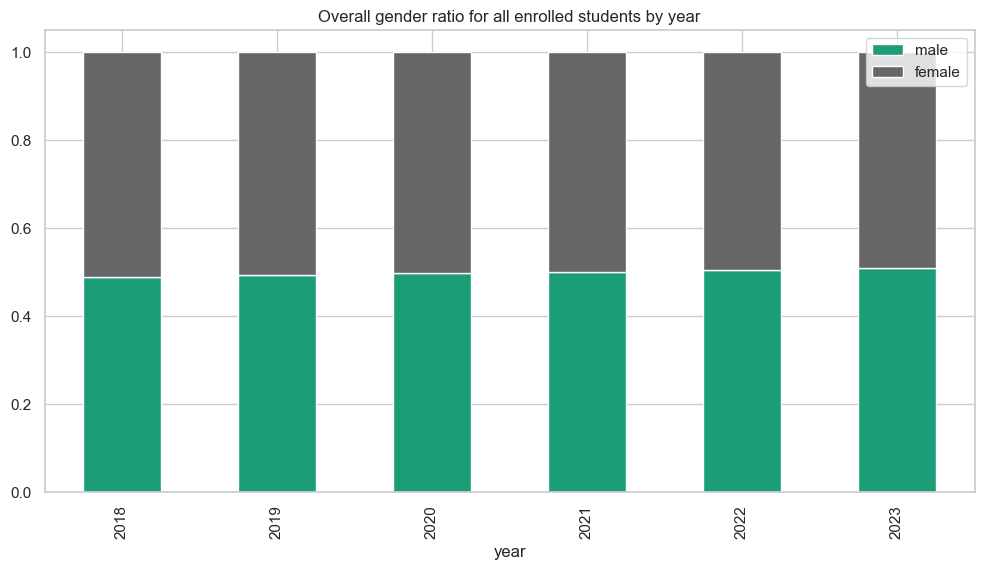

In [554]:
ax = df_s_genderyear.plot(kind='bar', stacked=True, colormap='Dark2')
ax.legend(['male','female'])
plt.title('Overall gender ratio for all enrolled students by year')
plt.show()

The graphic (and the chart) illustrates that between 2018 and 2023 the gender ratio among the total student population was around the 50% mark. The numerical data suggest a small increase of the number of female students overall.

The lineplot below shows this observation in closeup.

In [555]:
dfs_lp_gender = year_crosstab(df_s,'gender',norm=False).reset_index().melt(id_vars='year', var_name='gender', value_name='count')

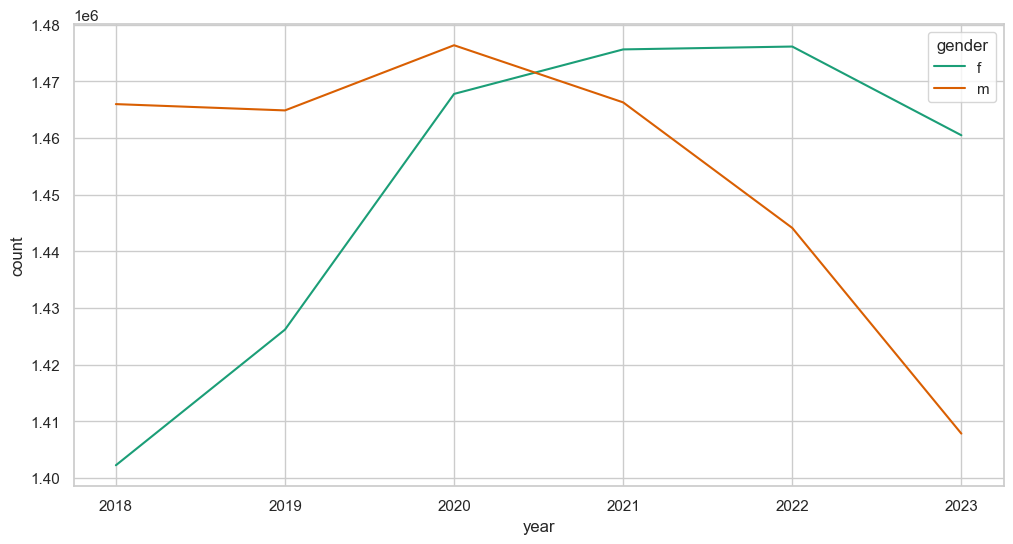

In [556]:
sns.lineplot(dfs_lp_gender,x='year',y='count',hue='gender',palette='Dark2');

In [557]:
df_s_natyear = year_crosstab(df_s,'nationality',norm=False)
df_s_natyear

nationality,domestic,foreign
year,,
2018,2473557,394665
2019,2479448,411601
2020,2527708,416437
2021,2501351,440564
2022,2462053,458210
2023,2398826,469485


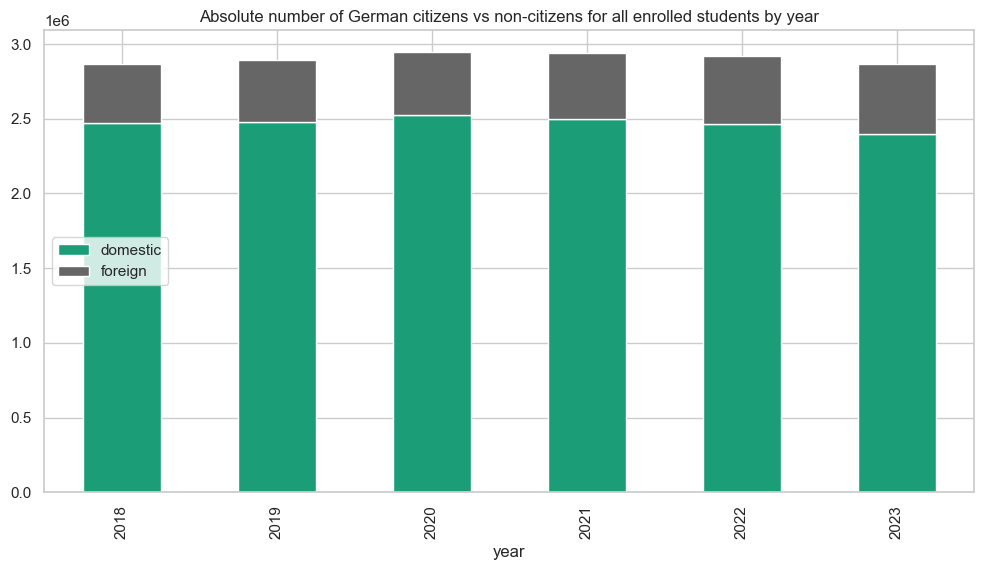

In [558]:
ax = df_s_natyear.plot(kind='bar', stacked=True, colormap='Dark2')
#ax.legend(['GER non-citizen','GER citizen'])
plt.title('Absolute number of German citizens vs non-citizens for all enrolled students by year')
plt.legend(loc='center left')
plt.show()

The barplot illustrates the overall decline in the number of students, but a slight increase in the number of foreign students over the time period.

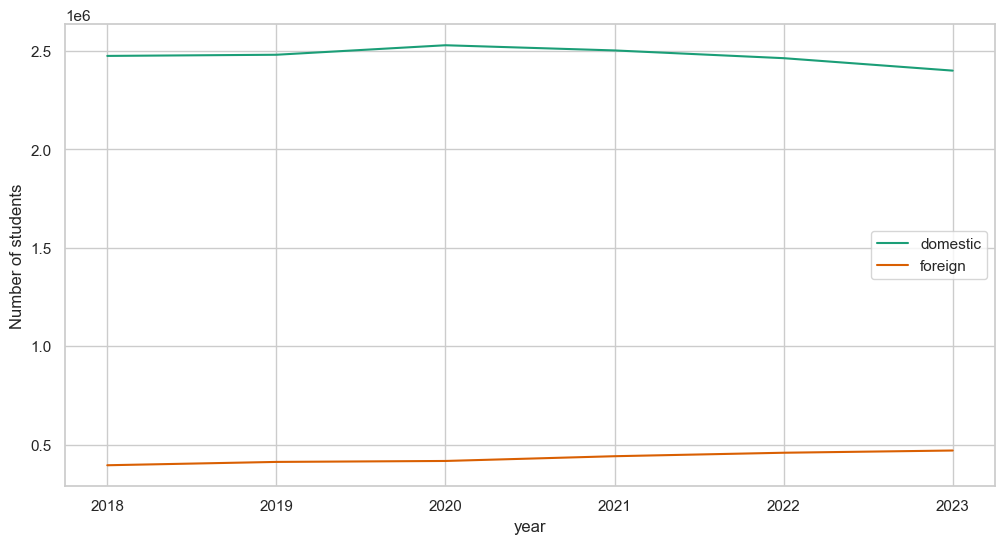

In [559]:
dfs_lp_nat = year_crosstab(df_s,'nationality',norm=False).reset_index().melt(id_vars='year', var_name='nationality', value_name='count')
sns.lineplot(dfs_lp_nat,x='year',y='count',hue='nationality',palette='Dark2')
plt.legend()
plt.ylabel('Number of students');

Naturally, to account for the overall decline in the number of students in spite of the slight increase in foreign students, the number of domestic students must have undergone a stronger decline. The lineplot shows the rise in absolute numbers for foreign students and the stronger decline in the number of students who are citizens in more detail.

### Incoming students/freshers

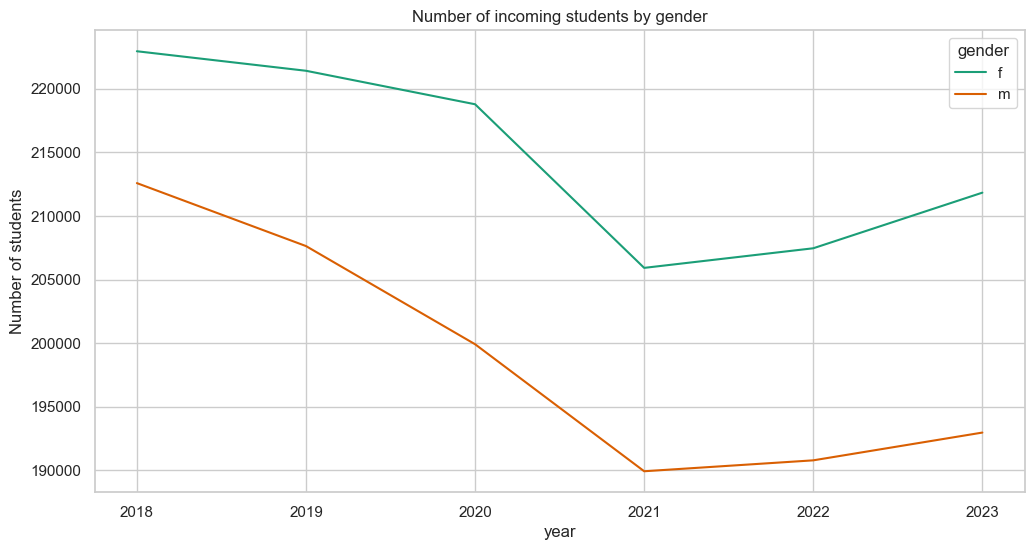

In [560]:
dff_lp_gender = year_crosstab(df_f,'gender',norm=False).reset_index().melt(id_vars='year', var_name='gender', value_name='count')
sns.lineplot(dff_lp_gender,x='year',y='count',hue='gender',palette='Dark2')
plt.title('Number of incoming students by gender')
plt.ylabel('Number of students');

This plot of the number of incoming students over the time period shows that the intake of female students has been consistently higher than the male intake over the whole period. So the swap in ratio observed for the total number of students in `df_s` above in 2021 is likely the result of a longer period of higher intake of female students rather than a specific change in intake patterns around 2021.

The graph also shows the overall dip in intake numbers irrespective of gender in 2021, likely related to the effects of COVID19. 

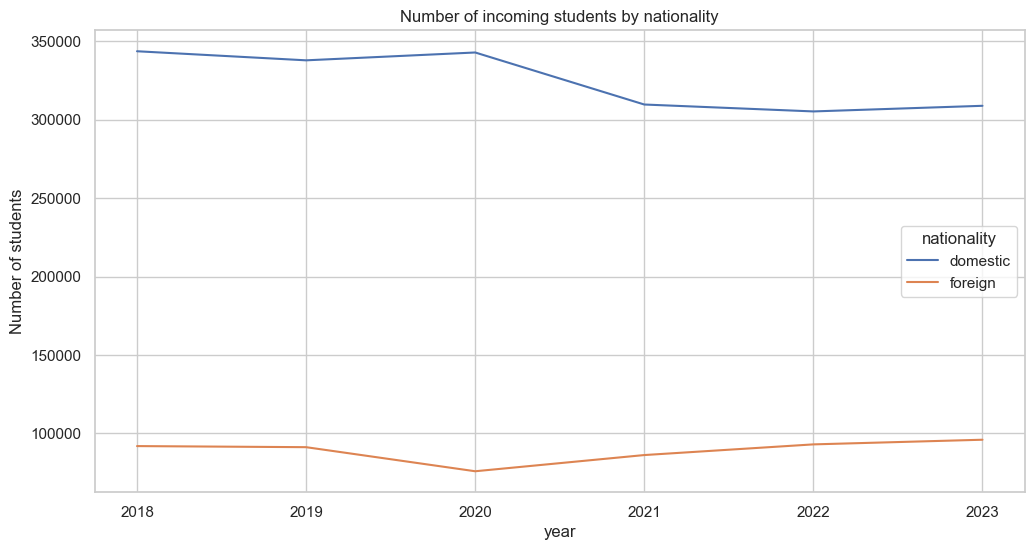

In [561]:
dff_lp_nat = year_crosstab(df_f,'nationality',norm=False).reset_index().melt(id_vars='year', var_name='nationality', value_name='count')
sns.lineplot(dff_lp_nat,x='year',y='count',hue='nationality')
plt.title('Number of incoming students by nationality')
plt.ylabel('Number of students');

## Bivariate analysis of gender and subject group

In [562]:
df_s_ext = pd.merge(df_s,subjcodes_s, how='left',on=['subj_code','subj_code'])

In [563]:
df_s_2023 = subsyear(df_s_ext,2023)
cross_gen_grp = pd.crosstab(df_s_2023.grp_name_en,df_s_2023.gender,values=df_s_2023.number,aggfunc='sum')#.reset_index(level='grp_name_en')
cross_gen_grp

gender,f,m
grp_name_en,,
"Agricultural, Forest and Nutritional Sciences, Veterinary Medicine",37981,22750
"Art, Art History",63354,34480
Engineering Sciences,189389,559316
Human Medicine/Health Sciences,143746,63288
Humanities,200420,97078
"Law, Economics and Social Sciences",657197,459425
"Mathematics, Natural Sciences",151683,149149
Outside the Study Area Classification,4534,3274
Sport,12177,19070


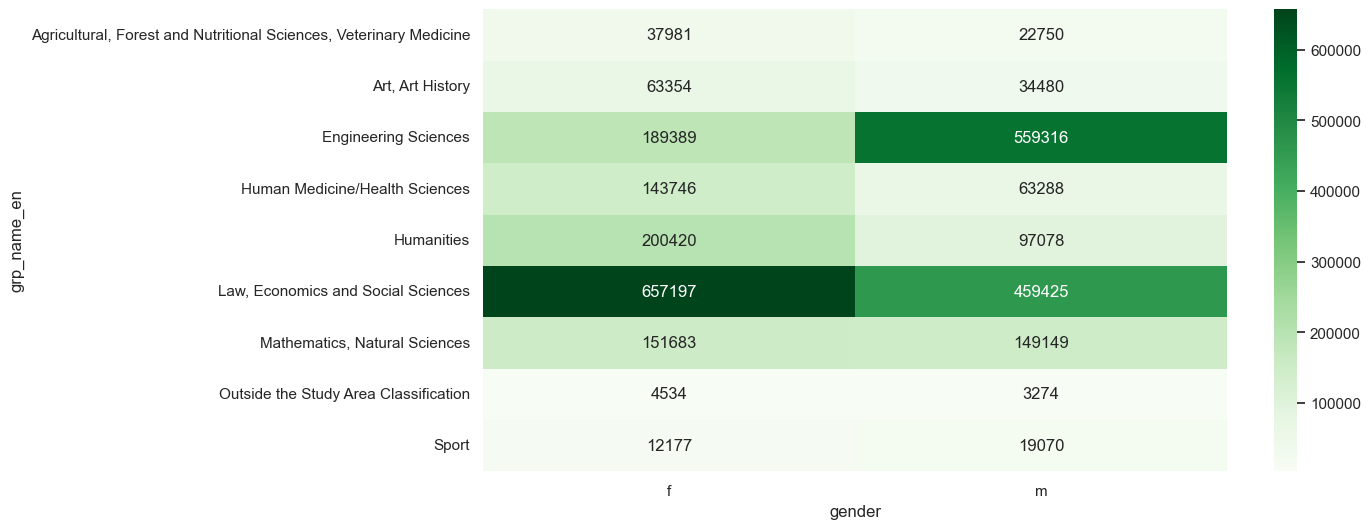

In [564]:
# visualise more coluorfully
sns.heatmap(cross_gen_grp, annot=True, cmap="Greens", fmt="3g");

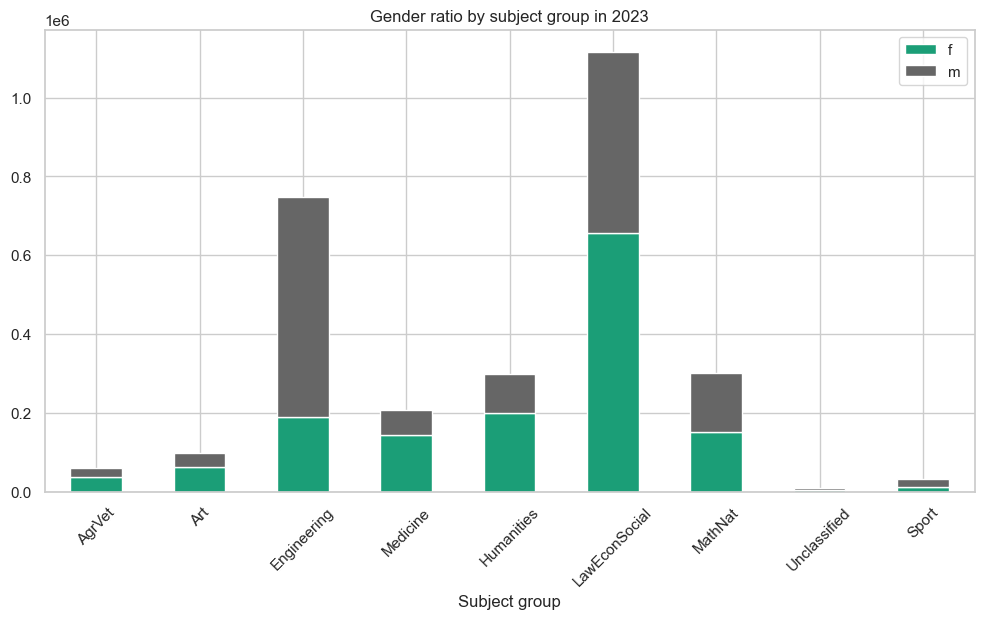

In [565]:
ax = cross_gen_grp.plot(kind='bar', stacked=True, colormap='Dark2')
ax.legend()
plt.title('Gender ratio by subject group in 2023')
plt.xticks(ticks=range(len(cross_gen_grp_norm.index)),labels=['AgrVet','Art','Engineering','Medicine','Humanities','LawEconSocial','MathNat','Unclassified','Sport'],rotation=45)
plt.xlabel('Subject group')
plt.show()

For clearer comparison of the ratio between groups, consider the normalised crosstable:

In [566]:
cross_gen_grp_norm = pd.crosstab(df_s_2023.grp_name_en,df_s_2023.gender,values=df_s_2023.number,aggfunc='sum',normalize='index')#.reset_index(level='grp_name_en')
cross_gen_grp_norm

gender,f,m
grp_name_en,,
"Agricultural, Forest and Nutritional Sciences, Veterinary Medicine",0.625397,0.374603
"Art, Art History",0.647566,0.352434
Engineering Sciences,0.252955,0.747045
Human Medicine/Health Sciences,0.694311,0.305689
Humanities,0.673685,0.326315
"Law, Economics and Social Sciences",0.588558,0.411442
"Mathematics, Natural Sciences",0.504212,0.495788
Outside the Study Area Classification,0.580686,0.419314
Sport,0.389701,0.610299


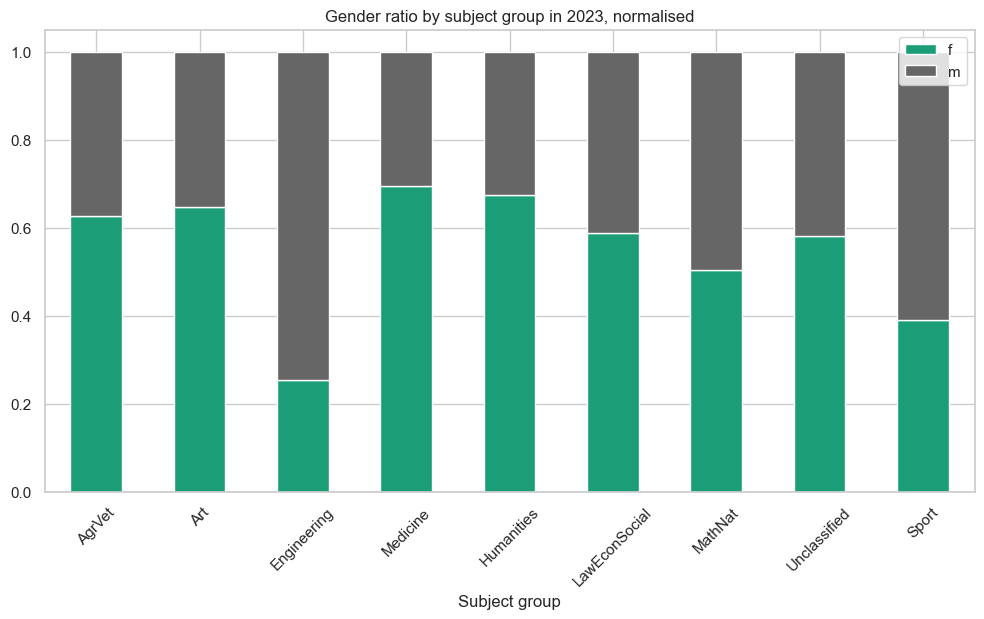

In [567]:
ax = cross_gen_grp_norm.plot(kind='bar', stacked=True, colormap='Dark2')
ax.legend()
plt.xlabel('Subject group')
plt.xticks(ticks=range(len(cross_gen_grp_norm.index)),labels=['AgrVet','Art','Engineering','Medicine','Humanities','LawEconSocial','MathNat','Unclassified','Sport'],rotation=45)
plt.title('Gender ratio by subject group in 2023, normalised')
plt.show()

This shows an overwhelming number of male students in Engineering and a prevalence of female students in AgrVet, Art, Medicine and Humanities.

To check whether there is a statistically significant interaction between gender and choice of subject (for the 2023 data), I am going to perform a chi-square test.

In [568]:
from scipy.stats import chi2_contingency

In [569]:
stat, chi2_pvalue, degfree, expect  = chi2_contingency(cross_gen_grp)
print(f'The chi-square value is {stat} with {degfree} degrees of freedom, corresponding to a p-value of {float(chi2_pvalue)}.')

The chi-square value is 298192.0422097183 with 8 degrees of freedom, corresponding to a p-value of 0.0.


The p-value < 0.001 suggests that the observed pattern would be very unlikely to observe if the choice of subject groups was independent from gender. The table below illustrates the actual distribution alongside the values that would be expected if the two factors were independent. 

In [570]:
# create combined table
expected_df = pd.DataFrame(expect, index=cross_gen_grp.index, columns=cross_gen_grp.columns)
cross_incl_expect = cross_gen_grp.join(round(expected_df,3),rsuffix='_expected')
#combined = cross_gen_grp.astype(str) + " (" + expected_df.round(2).astype(str) + ")"

import tabulate
print(cross_incl_expect[['f','f_expected','m','m_expected']].to_markdown())

| grp_name_en                                                        |      f |   f_expected |      m |   m_expected |
|:-------------------------------------------------------------------|-------:|-------------:|-------:|-------------:|
| Agricultural, Forest and Nutritional Sciences, Veterinary Medicine |  37981 |     30922.9  |  22750 |     29808.1  |
| Art, Art History                                                   |  63354 |     49814.9  |  34480 |     48019.1  |
| Engineering Sciences                                               | 189389 |    381224    | 559316 |    367481    |
| Human Medicine/Health Sciences                                     | 143746 |    105417    |  63288 |    101617    |
| Humanities                                                         | 200420 |    151479    |  97078 |    146019    |
| Law, Economics and Social Sciences                                 | 657197 |    568559    | 459425 |    548063    |
| Mathematics, Natural Sciences                 

### Time series

In [571]:
yeargroupsort = df_s_ext.groupby(['year','grp_name_en'])['number'].sum()

In [572]:
piv_grpsort = yeargroupsort.reset_index(name='count')

In [573]:
piv_grpsort = piv_grpsort.pivot(index = 'year',
                                columns = 'grp_name_en',
                                values='count')

In [574]:
piv_grpsort

grp_name_en,"Agricultural, Forest and Nutritional Sciences, Veterinary Medicine","Art, Art History",Engineering Sciences,Human Medicine/Health Sciences,Humanities,"Law, Economics and Social Sciences","Mathematics, Natural Sciences",Outside the Study Area Classification,Sport
year,,,,,,,,,
2018,62705,91890,774552,180916,336229,1066411,320236,6822,28461
2019,63715,92873,774687,186835,332473,1082326,321719,7214,29207
2020,64204,95934,782679,188774,326408,1128572,320187,6443,30944
2021,63277,97316,776744,196239,316442,1138785,314807,7148,31157
2022,62336,97927,763971,200906,310473,1132153,314395,7325,30777
2023,60731,97834,748705,207034,297498,1116622,300832,7808,31247


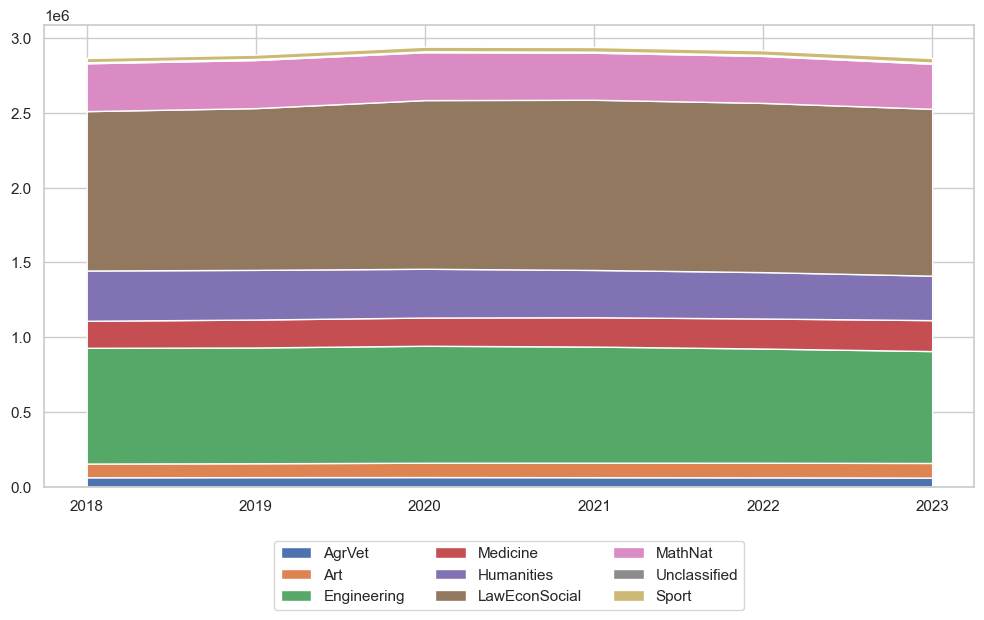

In [575]:
plt.stackplot(piv_grpsort.index,piv_grpsort.T,labels=piv_grpsort.columns)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, labels=['AgrVet','Art','Engineering','Medicine','Humanities','LawEconSocial','MathNat','Unclassified','Sport']);

In [576]:
df_s_ext.groupby(['year','grp_name_en'])['number'].sum().sort_values(ascending=False)

year  grp_name_en                                                       
2021  Law, Economics and Social Sciences                                    1138785
2022  Law, Economics and Social Sciences                                    1132153
2020  Law, Economics and Social Sciences                                    1128572
2023  Law, Economics and Social Sciences                                    1116622
2019  Law, Economics and Social Sciences                                    1082326
2018  Law, Economics and Social Sciences                                    1066411
2020  Engineering Sciences                                                   782679
2021  Engineering Sciences                                                   776744
2019  Engineering Sciences                                                   774687
2018  Engineering Sciences                                                   774552
2022  Engineering Sciences                                                   763971
202

In [577]:
total_bygrp = sum_univar(df_s_ext,'grp_name_en',norm=False)
total_bygrp

col_0,total
grp_name_en,
"Agricultural, Forest and Nutritional Sciences, Veterinary Medicine",376968
"Art, Art History",573774
Engineering Sciences,4621338
Human Medicine/Health Sciences,1160704
Humanities,1919523
"Law, Economics and Social Sciences",6664869
"Mathematics, Natural Sciences",1892176
Outside the Study Area Classification,42760
Sport,181793


In [578]:
#total_bygrp.plot(kind='bar',x='grp_name_en')

# SQL queries for research questions

In [579]:
# helper function
def asql(q,one=False):
    if one:
        with engine.connect() as conn:
            return conn.execute(q).scalar_one()
    else:
        with engine.connect() as conn:
            return conn.execute(q).fetchall()

1. What was the total number of students in Germany in 2023/24?

In [580]:
stmt = text("""
    SELECT SUM(number)
    FROM students
    WHERE year = 2023
""")

result = asql(stmt,one=True)
    
print(f'The total number of students in Germany in the academic year 2023/2024 was: {result}')

The total number of students in Germany in the academic year 2023/2024 was: 2868311


In [581]:
# alternative illustrating variable insertion with sqalchemy
stmt = text("""
    SELECT SUM(number)
    FROM students
    WHERE year = :year
""")

with engine.connect() as conn:
    result = conn.execute(stmt, {"year": 2023}).scalar_one()
    
print(result)


2868311



2. What were the 10 subjects with the highest number of students in 2023/24?

In [582]:
stmt = text("""
    SELECT subj_name,SUM(number) AS total_students
    FROM students
    WHERE year = 2023
    GROUP BY subj_code
    ORDER BY total_students DESC
    LIMIT 10
""")

result = asql(stmt)
    
print(f'The top ten subjects by absolute number of students in Germany in the academic year 2023/2024 were:')
pd.DataFrame(result)

The top ten subjects by absolute number of students in Germany in the academic year 2023/2024 were:


,subj_name,total_students
0,Betriebswirtschaftslehre,232475
1,Informatik,146170
2,Rechtswissenschaft,114515
3,Psychologie,113832
4,Medizin (Allgemein-Medizin),113383
5,Wirtschaftswissenschaften,86848
6,Soziale Arbeit,84405
7,Maschinenbau/-wesen,81646
8,Wirtschaftsinformatik,67909
9,Germanistik/Deutsch,63219


In [583]:
# Here's a version with English subject names
stmt = text("""
    SELECT st.subj_name_en,SUM(s.number) AS total_students
  	FROM students s
  	LEFT JOIN subject_taxonomy st ON s.subj_code = st.subj_code
    WHERE year = 2023
    GROUP BY s.subj_code
    ORDER BY total_students DESC
	LIMIT 10
            """)


result = asql(stmt)
    
print(f'The top ten subjects by absolute number of students in Germany in the academic year 2023/2024 were:')
topsubj_overall = pd.DataFrame(result)
topsubj_overall

The top ten subjects by absolute number of students in Germany in the academic year 2023/2024 were:


,subj_name_en,total_students
0,Business Administration,232475
1,Computer Science,146170
2,Law,114515
3,Psychology,113832
4,Medicine (General Medicine),113383
5,Economic Sciences,86848
6,Social Work,84405
7,Mechanical Engineering,81646
8,Business Informatics,67909
9,German Studies/German,63219



3. How was the gender distribution of students in 2023/24?


In [584]:
stmt = text("""
    SELECT gender,SUM(`number`) AS total
	FROM students s
	WHERE "year" = 2023
	GROUP BY gender
 """
)

result = asql(stmt)

pd.DataFrame(result)

,gender,total
0,f,1460481
1,m,1407830


4. How was the gender distribution in the 5 most studied subjects?

In [585]:
stmt = text("""
    WITH top_subjects AS (
    SELECT 
        subj_code,
        SUM(number) AS total_number
    FROM students
    WHERE year = 2023
    GROUP BY subj_code
    ORDER BY total_number DESC
    LIMIT 5
    )
    SELECT 
        st.subj_name_en,
        s.gender,
        SUM(s.number) AS gender_total
    FROM students s
    JOIN top_subjects ts ON s.subj_code = ts.subj_code
    LEFT JOIN subject_taxonomy st ON s.subj_code = st.subj_code
    WHERE s.year = 2023
    GROUP BY st.subj_name_en, s.gender
    ORDER BY st.subj_name_en, gender_total DESC;

 """
)

result = asql(stmt)

pd.DataFrame(result)

,subj_name_en,gender,gender_total
0,Business Administration,m,124566
1,Business Administration,f,107909
2,Computer Science,m,117598
3,Computer Science,f,28572
4,Law,f,67138
5,Law,m,47377
6,Medicine (General Medicine),f,73244
7,Medicine (General Medicine),m,40139
8,Psychology,f,87077
9,Psychology,m,26755


5. What were the top subjects by gender?


In [586]:
stmt = text("""
    SELECT gender, subj_name_en, total_number
    FROM (
        SELECT 
            s.gender,
            st.subj_name_en,
            SUM(s.number) AS total_number,
            RANK() OVER (
                PARTITION BY s.gender 
                ORDER BY SUM(s.number) DESC
            ) AS rnk
        FROM students s
        LEFT JOIN subject_taxonomy st ON s.subj_code = st.subj_code
        WHERE s.year = 2023
        GROUP BY s.gender, s.subj_code
    )
    WHERE rnk <= 10
    ORDER BY gender, total_number DESC;
 """
)

result = asql(stmt)

topsubj_gender = pd.DataFrame(result)
topsubj_gender

,gender,subj_name_en,total_number
0,f,Business Administration,107909
1,f,Psychology,87077
2,f,Medicine (General Medicine),73244
3,f,Law,67138
4,f,Social Work,65196
5,f,German Studies/German,49961
6,f,Educational Science (Pedagogy),46966
7,f,Economic Sciences,39638
8,f,Biology,37860
9,f,English Studies/English,34518


In [587]:
topsubj_gender['rank'] = topsubj_gender.groupby('gender')['total_number'].rank(method='first', ascending=False).astype(int)
topsubj_gender.pivot(index='rank',columns='gender',values='subj_name_en')

gender,f,m
rank,,
1,Business Administration,Business Administration
2,Psychology,Computer Science
3,Medicine (General Medicine),Mechanical Engineering
4,Law,Business Informatics
5,Social Work,Electrical Engineering/Electronics
6,German Studies/German,Law
7,Educational Science (Pedagogy),Economic Sciences
8,Economic Sciences,Industrial Engineering with Engineering Focus
9,Biology,Civil Engineering/Structural Engineering


6. Which were the top 10 subjects studied by foreigners? 


In [588]:
stmt = text("""
    SELECT st.subj_name_en,SUM(number) AS total_number
    FROM students s 
    LEFT JOIN subject_taxonomy st ON s.subj_code = st.subj_code
    WHERE s.nationality = 'foreign'
    GROUP BY s.subj_code
    ORDER BY total_number DESC
    LIMIT 10;
 """
)

result = asql(stmt)

topsubj_for = pd.DataFrame(result)
topsubj_for

,subj_name_en,total_number
0,Business Administration,182204
1,Computer Science,181931
2,Electrical Engineering/Electronics,131560
3,Mechanical Engineering,127336
4,International Business Administration/Management,84087
5,Medicine (General Medicine),79988
6,Economic Sciences,75160
7,Industrial Engineering with Engineering Focus,74530
8,Civil Engineering/Structural Engineering,68476
9,Law,57923


In [589]:
stmt = text("""
    SELECT st.subj_name_en,SUM(number) AS total_number
    FROM students s 
    LEFT JOIN subject_taxonomy st ON s.subj_code = st.subj_code
    WHERE s.nationality = 'domestic' AND s.year = 2023 
    GROUP BY s.subj_code
    ORDER BY total_number DESC
    LIMIT 10;
 """
)

result = asql(stmt)

topsubj_dom = pd.DataFrame(result)
topsubj_dom

,subj_name_en,total_number
0,Business Administration,197115
1,Computer Science,106602
2,Law,105381
3,Psychology,104492
4,Medicine (General Medicine),99065
5,Social Work,79371
6,Economic Sciences,72738
7,Mechanical Engineering,61398
8,German Studies/German,58110
9,Business Informatics,56740


In [590]:
display(pd.concat([topsubj_overall.subj_name_en,topsubj_dom.subj_name_en,topsubj_for.subj_name_en],axis=1,keys=['overall','domestic','foreign students']))

,overall,domestic,foreign students
0,Business Administration,Business Administration,Business Administration
1,Computer Science,Computer Science,Computer Science
2,Law,Law,Electrical Engineering/Electronics
3,Psychology,Psychology,Mechanical Engineering
4,Medicine (General Medicine),Medicine (General Medicine),International Business Administration/Management
5,Economic Sciences,Social Work,Medicine (General Medicine)
6,Social Work,Economic Sciences,Economic Sciences
7,Mechanical Engineering,Mechanical Engineering,Industrial Engineering with Engineering Focus
8,Business Informatics,German Studies/German,Civil Engineering/Structural Engineering
9,German Studies/German,Business Informatics,Law


In [592]:
print(pd.concat([topsubj_overall.subj_name_en,topsubj_dom.subj_name_en,topsubj_for.subj_name_en],axis=1,keys=['overall','domestic','foreign students']).to_markdown())

|    | overall                     | domestic                    | foreign students                                 |
|---:|:----------------------------|:----------------------------|:-------------------------------------------------|
|  0 | Business Administration     | Business Administration     | Business Administration                          |
|  1 | Computer Science            | Computer Science            | Computer Science                                 |
|  2 | Law                         | Law                         | Electrical Engineering/Electronics               |
|  3 | Psychology                  | Psychology                  | Mechanical Engineering                           |
|  4 | Medicine (General Medicine) | Medicine (General Medicine) | International Business Administration/Management |
|  5 | Economic Sciences           | Social Work                 | Medicine (General Medicine)                      |
|  6 | Social Work                 | Economic Sciences  

The two top course by nationality matches the top courses by nationality. Further below the ranking, unsurprisingly given their higher numbers, largely follows the trend of the domestic students with minor deviations.
Overall, the foreign students' top subjects suggest a stronger focus on technical and engineering-related subjects, whereas the domestic students' top ten contain a larger weight of social- and care-related subjects.

It might be interesting to crossreference this with the language requirements for those courses of studies to investigate to what extent this figures into the differences.

There is a strange fluke with Business Informatics showing up on rank 9 overall, but missing from both the domestic and foreign student rankings. I have not had time to investigate this further, but it indicates some sort of problem either with the data or the prompts.

7. How are the student numbers distributed across subject group?


In [330]:
stmt = text("""
    SELECT st.grp_name_en, SUM(s."number") AS student_count
    FROM students s 
    LEFT JOIN subject_taxonomy st ON s.subj_code = st.subj_code
    WHERE year = 2023
    GROUP BY st.grp_code 
    ORDER BY student_count DESC;
 """
)

result = asql(stmt)

pd.DataFrame(result)


,grp_name_en,student_count
0,"Law, Economics and Social Sciences",1116622
1,Engineering Sciences,748705
2,"Mathematics, Natural Sciences",300832
3,Humanities,297498
4,Human Medicine/Health Sciences,207034
5,"Art, Art History",97834
6,"Agricultural, Forest and Nutritional Sciences, Veterinary Medicine",60731
7,Sport,31247
8,Outside the Study Area Classification,7808


8. How does the number of incoming students change over the time period by subject group?


In [332]:
stmt = text("""
    SELECT st.grp_name_en,is2."year", SUM(is2."number") AS student_number
    FROM incoming_students is2 
    LEFT JOIN subject_taxonomy st ON is2.subj_code = st.subj_code
    GROUP BY st.grp_code,is2."year"
    ORDER BY st.grp_name_en, is2."year";
 """
)

result = asql(stmt)

pd.DataFrame(result)

,grp_name_en,year,student_number
0,"Agricultural, Forest and Nutritional Sciences, Veterinary Medicine",2018,9795
1,"Agricultural, Forest and Nutritional Sciences, Veterinary Medicine",2019,9812
2,"Agricultural, Forest and Nutritional Sciences, Veterinary Medicine",2020,9885
3,"Agricultural, Forest and Nutritional Sciences, Veterinary Medicine",2021,9089
4,"Agricultural, Forest and Nutritional Sciences, Veterinary Medicine",2022,8767
5,"Agricultural, Forest and Nutritional Sciences, Veterinary Medicine",2023,9261
6,"Art, Art History",2018,12350
7,"Art, Art History",2019,12452
8,"Art, Art History",2020,12279
9,"Art, Art History",2021,11986


9. How does the number of incoming students change over the time period for language related subjects?

I am including in this count all subject clusters with strong language-related aspects, i.e. also the different philologies.

In [333]:
# lang_clusters = ['07','08','09','10','11', '12', '13']      # maybe coding them as int wouldn't have been a bad idea after all

stmt = text("""
    SELECT is2."year", SUM(is2."number") AS student_number
    FROM incoming_students is2 
    LEFT JOIN subject_taxonomy st ON is2.subj_code = st.subj_code
    WHERE st.cluster_code IN ('07','08','09','10','11', '12', '13')
    GROUP BY is2."year"
    ORDER BY is2."year";
 """
)


result = asql(stmt)

pd.DataFrame(result)

,year,student_number
0,2018,30107
1,2019,29257
2,2020,26088
3,2021,23759
4,2022,23933
5,2023,24557


There is a noticable drop in intake numbers over the time period.

In [417]:
# and in more detail by subject cluster


stmt = text("""
    SELECT st.cluster_name_en,is2."year", SUM(is2."number") AS student_number
    FROM incoming_students is2 
    LEFT JOIN subject_taxonomy st ON is2.subj_code = st.subj_code
    WHERE st.cluster_code IN ('07','08','09','10','11', '12', '13')
    GROUP BY st.cluster_code,is2."year"
    ORDER BY st.cluster_code, is2."year";
 """
)


result = asql(stmt)

langclusters = pd.DataFrame(result)
langclusters

,cluster_name_en,year,student_number
0,General and Comparative Literature and Linguistics,2018,2947
1,General and Comparative Literature and Linguistics,2019,2977
2,General and Comparative Literature and Linguistics,2020,2704
3,General and Comparative Literature and Linguistics,2021,2487
4,General and Comparative Literature and Linguistics,2022,2417
5,General and Comparative Literature and Linguistics,2023,2598
6,"Classical Philology, Modern Greek",2018,471
7,"Classical Philology, Modern Greek",2019,402
8,"Classical Philology, Modern Greek",2020,330
9,"Classical Philology, Modern Greek",2021,258


There are intake drops across all surveyed subject clusters. Some (General and Comparative Lit and Ling, English Studies) have a slight uptick towards the end of the period, while others (Classical Philology/Modern Greek, Slavic Studies) have seen massive drops (particularly compared to their small absolute intake).

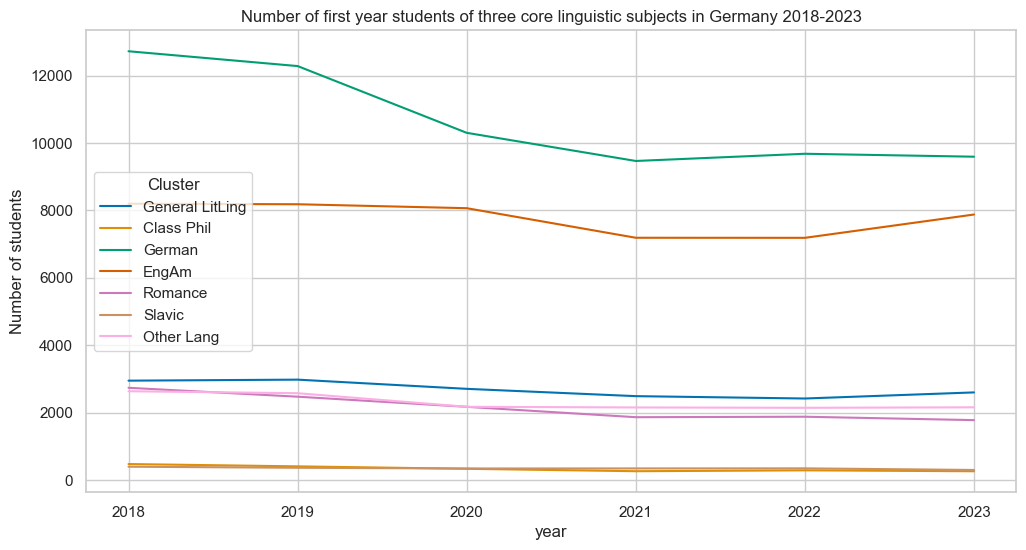

In [424]:
sns.lineplot(langclusters,x='year',y='student_number',hue='cluster_name_en',palette='colorblind')
# After your Seaborn plot
handles, labels = plt.gca().get_legend_handles_labels()

# Then manually map them to your new desired labels
new_labels = ['General LitLing', 'Class Phil', 'German', 'EngAm', 'Romance', 'Slavic', 'Other Lang']

plt.legend(title='Cluster',handles=handles, labels=new_labels, loc='center left')
plt.ylabel('Number of students')
plt.title('Number of first year students of three core linguistic subjects in Germany 2018-2023');

10. How does the number of incoming students change for linguistics in a narrow perspective? (only General Linguistics/Indoeuropean Studies, Applied Linguistics, Computational Linguistics)

In [335]:
stmt = text("""
    SELECT is2."year", SUM(is2."number") AS student_number
    FROM incoming_students is2 
    LEFT JOIN subject_taxonomy st ON is2.subj_code = st.subj_code
    WHERE is2.subj_code IN ('152','284','160')
    GROUP BY is2."year"
    ORDER BY is2."year";
 """
)

result = asql(stmt)

pd.DataFrame(result)

,year,student_number
0,2018,2153
1,2019,2084
2,2020,1911
3,2021,1670
4,2022,1632
5,2023,1793


There is an overall drop across the timeframe, albeit a slight uptick for the last year of record (in line with the observation for cluster 07). 

In [342]:
stmt = text("""
   SELECT st.subj_name_en, is2."year", SUM(is2."number") AS student_number
    FROM incoming_students is2 
    LEFT JOIN subject_taxonomy st ON is2.subj_code = st.subj_code
    WHERE is2.subj_code IN ('152','284','160')
    GROUP BY is2.subj_code, is2."year"
    ORDER BY is2.subj_code, is2."year";
 """
)

result = asql(stmt)

ling_years= pd.DataFrame(result)
ling_years

,subj_name_en,year,student_number
0,General Linguistics/Indo-European Studies,2018,1034
1,General Linguistics/Indo-European Studies,2019,989
2,General Linguistics/Indo-European Studies,2020,990
3,General Linguistics/Indo-European Studies,2021,808
4,General Linguistics/Indo-European Studies,2022,791
5,General Linguistics/Indo-European Studies,2023,970
6,Computational Linguistics,2018,234
7,Computational Linguistics,2019,225
8,Computational Linguistics,2020,215
9,Computational Linguistics,2021,262


Text(0.5, 1.0, 'Number of first year students of three core linguistic subjects in Germany 2018-2023')

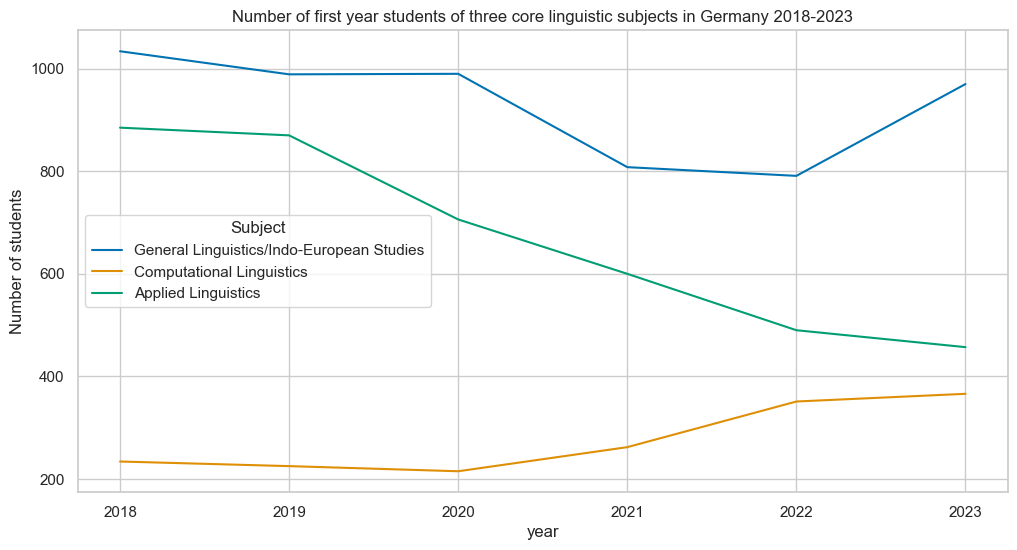

In [416]:
sns.lineplot(ling_years,x='year',y='student_number',hue='subj_name_en',palette='colorblind')
plt.legend(title='Subject')
plt.ylabel('Number of students')
plt.title('Number of first year students of three core linguistic subjects in Germany 2018-2023')

General Linguistics as the largest subject sets the overall trend of a general fall in numbers with a slight uptick.
Applied Linguistics displays a constant (and quite intense, almost 50% in total!) drop.
Computational Linguistics is the only subject bucking the trend with a relatively strong growth over the period, even (and especially?) in the immediate period after the onset of COVID19 restrictions.

Given the popularity of technical subjects overall and the specific rising interest in language technology, particularly the final observation is not too surprising. The alarming decline of Applied Linguistics raises important questions about possible systematic issues with the popularity of the subject.
The trend for General Linguistics is not as alarming and the increase in intake from 2022 to 2023 may suggest that the strong drops in 2021 and 2022 were influenced by COVID.

11. Which 10 subjects saw the highest percentual drop in intake from 2018 to 2023?


In [341]:
stmt = text("""
    WITH year_bounds AS (
        SELECT MIN(year) AS first_year, MAX(year) AS last_year FROM incoming_students is2 
    ),
    aggregated AS (
        SELECT
            subj_code,
            year,
            SUM(number) AS total_intake
        FROM incoming_students is2 
        GROUP BY subj_code, year
    ),
    filtered AS (
        SELECT a.subj_code, a.total_intake, a.year, y.first_year, y.last_year
        FROM aggregated a
        JOIN year_bounds y ON a.year = y.first_year OR a.year = y.last_year
    ),
    pivoted AS (
        SELECT
            subj_code,
            MAX(CASE WHEN year = first_year THEN total_intake END) AS intake_first_year,
            MAX(CASE WHEN year = last_year THEN total_intake END) AS intake_last_year
        FROM filtered
        GROUP BY subj_code
    )
    SELECT
        st.subj_name_en,
        st.subj_name,
        intake_first_year,
        intake_last_year,
        ROUND(
            (CAST(intake_last_year - intake_first_year AS FLOAT) / NULLIF(intake_first_year, 0)) * 100,
            2
        ) AS percentual_change
    FROM pivoted
    LEFT JOIN subject_taxonomy st ON pivoted.subj_code = st.subj_code
    WHERE percentual_change IS NOT NULL AND percentual_change > -100
    ORDER BY percentual_change
    LIMIT 10;
 """
)

result = asql(stmt)

pd.DataFrame(result)

,subj_name_en,subj_name,intake_first_year,intake_last_year,percentual_change
0,Russian,Russisch,118,21,-82.20
1,Caritas Studies,Caritaswissenschaft,9,2,-77.78
2,Sorbian Studies,Sorabistik,8,2,-75.00
3,Animal Production,Tierproduktion,8,2,-75.00
4,Metallurgy and Foundry Technology,Hütten- und Gießereiwesen,120,32,-73.33
5,Glass Technology/Ceramics,Glastechnik/Keramik,21,6,-71.43
6,Polish,Polnisch,17,5,-70.59
7,Byzantine Studies,Byzantinistik,6,2,-66.67
8,Waste Management,Abfallwirtschaft,24,8,-66.67
9,Economic/Social Geography,Wirtschafts-/Sozialgeographie,6,2,-66.67


12. Which 10 subjects saw the highest percentual rise in intake from 2018 to 2023?


In [ ]:
stmt = text("""
    WITH year_bounds AS (
        SELECT MIN(year) AS first_year, MAX(year) AS last_year FROM incoming_students is2 
    ),
    aggregated AS (
        SELECT
            subj_code,
            year,
            SUM(number) AS total_intake
        FROM incoming_students is2 
        GROUP BY subj_code, year
    ),
    filtered AS (
        SELECT a.subj_code, a.total_intake, a.year, y.first_year, y.last_year
        FROM aggregated a
        JOIN year_bounds y ON a.year = y.first_year OR a.year = y.last_year
    ),
    pivoted AS (
        SELECT
            subj_code,
            MAX(CASE WHEN year = first_year THEN total_intake END) AS intake_first_year,
            MAX(CASE WHEN year = last_year THEN total_intake END) AS intake_last_year
        FROM filtered
        GROUP BY subj_code
    )
    SELECT
        st.subj_name_en,
        intake_first_year,
        intake_last_year,
        ROUND(
            (CAST(intake_last_year - intake_first_year AS FLOAT) / NULLIF(intake_first_year, 0)) * 100,
            2
        ) AS percentual_change
    FROM pivoted
    LEFT JOIN subject_taxonomy st ON pivoted.subj_code = st.subj_code
    WHERE percentual_change IS NOT NULL
    ORDER BY percentual_change DESC
    LIMIT 10;

 """
)

result = asql(stmt)

pd.DataFrame(result)


,subj_name_en,intake_first_year,intake_last_year,percentual_change
0,Mineralogy,2,37,1750.00
1,Crop Production,16,78,387.50
2,General Studies (incl. School Garden),85,253,197.65
3,Library Science,5,12,140.00
4,Mine Surveying,4,9,125.00
5,Islamic Studies/Islamic Theology,69,155,124.64
6,Nature Conservation,81,180,122.22
7,Microelectronics,34,73,114.71
8,Materials Science,272,532,95.59
9,Prehistory and Early History,60,114,90.00
